In [1]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
rm -rf hw2
git clone https://github.com/mit-6864/hw2.git

Cloning into 'hw2'...


In [2]:
import sys
sys.path.append("/content/hw2")

import csv
import itertools as it
import numpy as np
import sklearn.decomposition
from tqdm import tqdm
# import lab_util
import random

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993225 sha256=dbba36572f4ed678ca3727da01e158fbc13265ad698167d59441f8a94aa7142d
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [4]:
from langdetect import detect
import re

def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

def clean_csv(csv_file):
  with open(csv_file) as reader:
    csvreader = csv.reader(reader)
    next(csvreader)
    rows = list(csvreader)
    random_tweets = random.sample(rows, 3000)

  sampling_pool = []
  for row in random_tweets:
    try:
      if len(row) >= 3 and detect(row[2]) == 'en':
        sampling_pool.append(row)
    except:
      pass

  sampling_pool = random.sample(sampling_pool, 500)
  cleaned_samples = []
  for sample in sampling_pool:
    split_tweet = sample[2].split()
    cleaned_words = []
    for word in split_tweet:
      if 'https:' not in word and '@' not in word and (word.isalpha() or word[0] == '#'):
        if not word.lower() in ['#joebiden', '#trump2020', '#biden2020', '#donaldtrump', '#auspol', '#ausvotes', '#ausvotes19', '#ausvote19', '#ausvote2019','#ausvotes2019','#trump', '#biden', '#donaldjtrump']:
          cleaned_words.append(remove_emojis(word))
    cleaned_samples.append((' '.join(cleaned_words), 1))
  return cleaned_samples

In [5]:
cleaned_joe = clean_csv('/content/drive/MyDrive/NLP-Political-Polarity/hashtag_joebiden.csv')
cleaned_donald = clean_csv('/content/drive/MyDrive/NLP-Political-Polarity/hashtag_donaldtrump.csv')
cleaned_aus = clean_csv('/content/drive/MyDrive/NLP-Political-Polarity/auspol2019.csv')

In [ ]:
print(cleaned_joe[284])
print(cleaned_donald[:10])
print(cleaned_aus[:10])

('This is my second night without sleep totally worth it I may say different tomorrow #ElectionResults2020 #Election2020', 1)
[('Every vote for is a vote AGAINST dignity and Shame on #USElection2020', 1), ('my forecast on what happens #Trump2020LandslideVictory #270towin #Trump2020Landslide #BidenHarris2020 #VOTE', 1), ("would be the greatest The greatest If #Trump's #1 priority is #winning and we know it then he would try but he knows he #BidenHarris2020 has been raising", 1), ('Pathological Lying is a pervasive compulsive pattern of excessive lying behavior that leads to significant impairment of PL not yet classified as diagnostic entity in or but should with so on Nov wins', 1), ("#Trump's #signature looks like the #stabbing action in the shower scene and AMERICANS DIED BECAUSE OF HIS MALIGN Just read a analysis of his handwriting by an Charles", 1), ('President did not finish what he came for in the There are no indications of his But the he must stay to complete the work #IVoted'

In [6]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.9 MB/s eta 0:00:00


In [7]:
from datasets import load_dataset

dataset = load_dataset("tweet_eval", "irony")

Extracting data files:   0%|          | 0/6 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/2862 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/784 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/955 [00:00<?, ? examples/s]

In [8]:
sampling_pool = random.sample(dataset['train']['text'], 1500)
cleaned_samples_nonpolitical = []
for sample in sampling_pool:
  sample = remove_emojis(sample)
  split_tweet = sample.split()
  # print(split_tweet)
  cleaned_words = []
  for word in split_tweet:
    word = word.replace('.','')
    if 'https:' not in word and '@' not in word and len(word) >= 3 and (word.isalpha() or word[0] == '#'):
      cleaned_words.append(remove_emojis(word))
  cleaned_samples_nonpolitical.append((' '.join(cleaned_words), 0))

In [ ]:
len(cleaned_samples_nonpolitical)

2100

In [ ]:
# cleaned_scrape = []
# with open('./tweets.csv') as reader:
#   csvreader = csv.reader(reader)
#   next(csvreader)
#   rows = list(csvreader)
#   for row in rows:
#     label = int(row[2])
#     split_tweet = row[3].split()
#     cleaned_words = []
#     for word in split_tweet:
#       if 'http' not in word and '@' not in word:  #and (word.isalpha() or word[0] == '#') and len(word) >=2:
#         cleaned_words.append(remove_emojis(word))
#     cleaned_scrape.append((' '.join(cleaned_words), label))

In [9]:
cleaned_data = cleaned_joe.copy()
cleaned_data.extend(cleaned_donald)
cleaned_data.extend(cleaned_samples_nonpolitical)
# cleaned_data.extend(cleaned_scrape)
cleaned_data.extend(cleaned_aus)
np.random.seed(0)
np.random.shuffle(cleaned_data)
tweets, labels = zip(*cleaned_data)

In [ ]:
print(len(tweets))

4200


In [10]:
train_tweets, train_labels = tweets[:2200], labels[:2200]
val_tweets, val_labels = tweets[2200:2600], labels[2200:2600]
test_tweets, test_labels = tweets[2600:], labels[2600:]

In [11]:
def remove_empty(tweet, label):
  new_tweets = []
  new_labels = []
  for i in range(len(tweet)):
    if len(tweet[i]):
      new_tweets.append(tweet[i])
      new_labels.append(label[i])
  return new_tweets, new_labels

In [12]:
train_tweets, train_labels = remove_empty(train_tweets, train_labels)
val_tweets, val_labels = remove_empty(val_tweets, val_labels)
test_tweets, test_labels = remove_empty(test_tweets, test_labels)

In [ ]:
print(len(test_tweets))

302


In [14]:
import numpy as np
import re
import string
import random

def show_similar_words(tokenizer, reps, tokens):
    reps = reps / (np.sqrt((reps ** 2).sum(axis=1, keepdims=True)))
    #for i, (word, token) in enumerate(tokenizer.word_to_token.items()):
    for token in tokens:
        word = tokenizer.token_to_word[token]
        rep = reps[token, :]
        sims = ((reps - rep) ** 2).sum(axis=1)
        nearest = np.argsort(sims)
        print(word, token)
        for j in nearest[1:6]:
            print(" ", tokenizer.token_to_word[j], "%.3f" % sims[j])

class Tokenizer:
  def __init__(self, min_occur=1):
    self.word_to_token = {}
    self.token_to_word = {}
    self.word_count = {}

    self.word_to_token['pad'] = 0
    self.token_to_word[0] = 'pad'
    self.word_to_token['<unk>'] = 1
    self.token_to_word[1] = '<unk>'
    self.word_to_token['<s>'] = 2
    self.token_to_word[2] = '<s>'
    self.word_to_token['</s>'] = 3
    self.token_to_word[3] = '</s>'
    self.vocab_size = 4

    self.min_occur = min_occur

  def fit(self, corpus):
    for review in corpus:
      review = review.strip().lower()
      words = re.findall(r"[a-zA-Z_0-9|#']+|[.,!?;]", review)
      for word in words:
          if len(word) > 2:
            if word not in self.word_count:
                self.word_count[word] = 0
            self.word_count[word] += 1

    for review in corpus:
      review = review.strip().lower()
      words = re.findall(r"[a-zA-Z_0-9|#']+|[.,!?;]", review)
      for word in words:
        if len(word) > 2:
          if self.word_count[word] < self.min_occur:
            continue
          if word in self.word_to_token:
            continue
          self.word_to_token[word] = self.vocab_size
          self.token_to_word[self.vocab_size] = word
          self.vocab_size += 1

  def tokenize(self, corpus):
    tokenized_corpus = []
    for review in corpus:
      review = review.strip().lower()
      words = re.findall(r"[a-zA-Z_0-9|#']+|[.,!?;]", review)
      tokenized_review = []
      for word in words:
        if word not in self.word_to_token:
          tokenized_review.append(0)
        else:
          tokenized_review.append(self.word_to_token[word])
      tokenized_corpus.append(tokenized_review)
    return tokenized_corpus

  def de_tokenize(self, tokenized_corpus):
    corpus = []
    for tokenized_review in tokenized_corpus:
      review = []
      for token in tokenized_review:
        review.append(self.token_to_word[token])
      corpus.append(" ".join(review))
    return corpus


class CountVectorizer:
  def __init__(self, min_occur=1):
    self.tokenizer = Tokenizer(min_occur)

  def fit(self, corpus):
    self.tokenizer.fit(corpus)

  def transform(self, corpus):
    n = len(corpus)
    X = np.zeros((n, self.tokenizer.vocab_size))
    print(X.shape)
    for i, review in enumerate(corpus):
      review = review.strip().lower()
      words = re.findall(r"[a-zA-Z_0-9|#']+|[.,!?;]", review)
      # print(review)
      # print(words)
      # print('------')
      for word in words:
        if word not in self.tokenizer.word_count or self.tokenizer.word_count[word] < self.tokenizer.min_occur:
          X[i][0] += 1
        else:
          X[i][self.tokenizer.word_to_token[word]] += 1
    return X


In [15]:
vectorizer = CountVectorizer()
vectorizer.fit(train_tweets+val_tweets+test_tweets)
bow_matrix = vectorizer.transform(train_tweets)
print(f"BoW matrix is {bow_matrix.shape[0]} x {bow_matrix.shape[1]}")

(2191, 9306)
BoW matrix is 2191 x 9306


In [ ]:
print(vectorizer.tokenizer.vocab_size)

10415


In [16]:
def get_ngrams(tokenized_corpus, window_size, pad_idx=bow_matrix.shape[1]):
    ngrams = []
    for i, review in enumerate(tokenized_corpus):
        for j, word in enumerate(review):
            min_ind = max(0, j-window_size)
            max_ind = min(len(review), j+window_size+1)
            ctx = np.zeros(2 * window_size, dtype=np.int64) + pad_idx
            for ik, k in enumerate(range(min_ind, j)):
                ctx[ik] = review[k]
            for ik, k in enumerate(range(j+1, max_ind)):
                ctx[window_size+ik] = review[k]
            ngrams.append((ctx, review[j]))
    return ngrams

In [23]:
for i in range(bow_matrix.shape[0]):
  if np.sum(bow_matrix[i]) == 0:
    print(i,'0')
print(bow_matrix[284].shape)

(9150,)


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as torch_data

class Word2VecModel(nn.Module):
    # A torch module implementing a word2vec predictor. The `forward` function
    # should take a batch of context word ids as input and predict the word
    # in the middle of the context as output, as in the CBOW model from lecture.
    # Hint: look at how padding is handled in lab_util.get_ngrams when
    # initializing `ctx`: vocab_size is used as the padding token for contexts
    # near the beginning and end of sequences. If you use an embedding module
    # in your Word2Vec implementation, make sure to account for this extra
    # padding token in the input dimension and include the `padding_idx` kwarg.

    def __init__(self, vocab_size, embedding_size, padding_idx=bow_matrix.shape[1]):
        super().__init__()
        # pass in padding idx
        # create layers
        # Your code here!
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size+1, embedding_size, padding_idx)
        self.linear1 = nn.Linear(embedding_size, vocab_size)
        # self.linear2 = nn.Linear(100, vocab_size)
        #self.linear1 = nn.Linear(hidden, 1)
        self.softmax = nn.Softmax()

    def forward(self, context):
        # Context is an `n_batch x n_context` matrix of integer word ids.
        # In this case, n_context = 2 * window_size where window_size is defined
        # in lab_util.py. This is because each word has both left and right context.
        # This function should return an `n_batch x vocab_size` matrix with
        # element i, j being the (possibly log) probability of the middle word
        # in context i being word j.

        # Your code here!
        # take embedding of each context, sum, pass thru linear, softmax and return
        return_mat = torch.zeros((context.shape[0], self.vocab_size))
        for batch in range(context.shape[0]):
          ctx = context[batch, :]
          ctx_embedding = self.embedding(ctx)
          summed_ctx = torch.sum(ctx_embedding, dim=0)
          linear1 = self.linear1(summed_ctx)
          # linear2 = self.linear2(linear1)
          # linear = self.linear(prev_layer)
          softmax = self.softmax(linear1)
          log_softmax = torch.log(softmax)
          return_mat[batch, :] = log_softmax
        return return_mat

In [18]:
def learn_reps_word2vec(corpus, window_size, rep_size, n_epochs, n_batch):
    # This method takes in a corpus of training sentences. It returns a matrix of
    # word embeddings with the same structure as used in the previous section of
    # the assignment. (You can extract this matrix from the parameters of the
    # Word2VecModel.)

    tokenizer = Tokenizer()
    tokenizer.fit(corpus)
    tokenized_corpus = tokenizer.tokenize(corpus)
    ngrams = get_ngrams(tokenized_corpus, window_size, pad_idx=bow_matrix.shape[1])
    model = Word2VecModel(tokenizer.vocab_size, rep_size).to(device)
    # print(model.linear2.weight.data)
    opt = optim.Adam(model.parameters(), lr=0.0001)

    loader = torch_data.DataLoader(ngrams, batch_size=n_batch, shuffle=True)

    # What loss function should we use for Word2Vec?
    loss_fn = nn.CrossEntropyLoss()

    losses = []  # Potentially useful for debugging (loss should go down!)
    for epoch in tqdm(range(n_epochs)):
        epoch_loss = 0
        for context, label in loader:
            # As described above, `context` is a batch of context word ids, and
            # `label` is a batch of predicted word labels.

            # Here, perform a forward pass to compute predictions for the model.
            # Your code here!
            context=context.to(device)
            preds = model(context)
            # print(preds)


            # Now finish the backward pass and gradient update.
            # Remember, you need to compute the loss, zero the gradie nts
            # of the model parameters, perform the backward pass, and
            # update the model parameters.
            # Your code here!
            label = label.to(device)
            loss = loss_fn(preds.to(device), label)
            loss.backward()
            opt.step()
            opt.zero_grad()

            epoch_loss += loss.item()
        losses.append(epoch_loss)

    # Hint: you want to return a `vocab_size x embedding_size` numpy array
    embedding_matrix = model.linear1.weight.data.cpu().numpy() # Your code here! #.weight.cpu()

    return [embedding_matrix, losses]

In [19]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
assert device == "cuda"   # use gpu whenever you can!

In [ ]:
reps_word2vec, losses = learn_reps_word2vec(train_tweets+val_tweets+test_tweets, 2, 2000, 30, 100)

100%|██████████| 30/30 [1:13:45<00:00, 147.51s/it]


In [ ]:
torch.save(reps_word2vec, 'naiveword2vec.pt')

In [30]:
print(np.count_nonzero(np.isnan(reps_word2vec)))
print(np.count_nonzero(reps_word2vec))
print(reps_word2vec)

0
18300000
[[-0.05347691 -0.0392684   0.0116086  ...  0.01830395  0.03390661
  -0.03603811]
 [ 0.0757068  -0.01834722  0.02030795 ... -0.03106627 -0.00877471
   0.02289942]
 [ 0.05991736 -0.02486258  0.01330359 ... -0.03940108 -0.02121144
   0.0354825 ]
 ...
 [ 0.05009458 -0.02086856 -0.00014381 ... -0.00677247 -0.01562107
  -0.01568561]
 [ 0.04849561  0.00746018  0.00524151 ... -0.058438   -0.02470169
  -0.01090059]
 [ 0.02090721 -0.00774441  0.01420358 ... -0.01003057 -0.00144291
  -0.00911079]]


Text(0, 0.5, 'Loss')

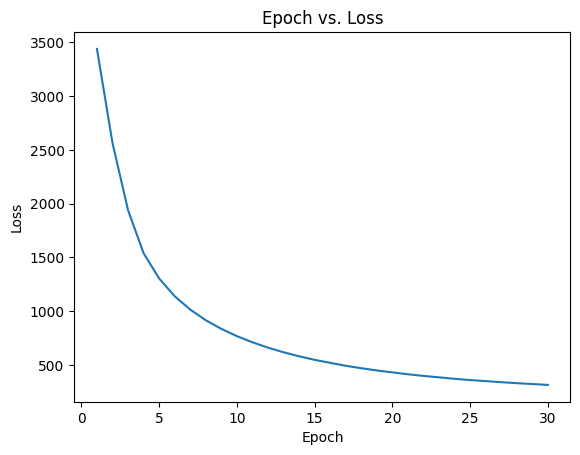

In [31]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(range(1,31), losses)
plt.title('Epoch vs. Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [164]:
# scaling hashtagged words
word2tok = vectorizer.tokenizer.word_to_token
def scale_rep(factor):
  scaled_reps = np.zeros(reps_word2vec.shape)
  for word in word2tok:
    if word[0] == '#':
      scaled_reps[word2tok[word]] = reps_word2vec[word2tok[word]] * factor
    else:
      scaled_reps[word2tok[word]] = reps_word2vec[word2tok[word]]
  return scaled_reps

In [165]:
import sklearn.linear_model
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

def train_model(featurizer, xs, ys):
    xs_featurized = featurizer(xs)
    model = sklearn.linear_model.LogisticRegression(penalty='none', max_iter=1000)
    model.fit(xs_featurized, ys)
    return model

def eval_model(model, featurizer, xs, ys, scaled_reps = None):
    if not scaled_reps is None:
      xs_featurized = featurizer(xs, scaled_reps)
    else:
      xs_featurized = featurizer(xs)
    if np.any(np.isnan(xs_featurized)):
      print('hi')
    pred_ys = model.predict(xs_featurized)
    return [np.mean(pred_ys == ys), pred_ys]


def training_experiment(name, featurizer, n_train, scaled_featurizer = None, scaled_reps = None):
    print(f"{name} features, {n_train} examples")
    train_xs = vectorizer.transform(train_tweets[:n_train])
    train_ys = train_labels[:n_train]
    test_xs = vectorizer.transform(test_tweets)
    test_ys = test_labels
    model = train_model(featurizer, train_xs, train_ys)
    acc, pred = eval_model(model, featurizer, test_xs, test_ys)
    if scaled_featurizer:
      scaled_acc, preds = eval_model(model, scaled_featurizer, test_xs, test_ys, scaled_reps = scaled_reps)
      print(acc, '\n')
      print(scaled_acc, '\n')
      return [acc, scaled_acc, preds]
    print(acc, '\n')
    return acc, pred

In [34]:
print(vectorizer.tokenizer.vocab_size)

9150


In [166]:
from sklearn.metrics import f1_score, precision_score, recall_score

def w2v_featurizer(xs):
    # This function takes in a matrix in which each row contains the word counts
    # for the given review. It should return a matrix in which each row contains
    # the average Word2Vec embedding of each review (hint: this will be very
    # similar to `lsa_featurizer` from above, just using Word2Vec embeddings
    # instead of LSA).
    feats = np.matmul(xs, reps_word2vec)
    # normalize
    feats = feats / np.sqrt((feats ** 2).sum(axis=1, keepdims=True))
    for i in range(len(feats)):
      if np.any(np.isnan(feats[i])):
        feats[i] = np.zeros(reps_word2vec.shape[1])
    return feats
    # return feats / np.sqrt((feats ** 2).sum(axis=1, keepdims=True))

def w2v_featurizer_scaled(xs, scaled_reps):
    # This function takes in a matrix in which each row contains the word counts
    # for the given review. It should return a matrix in which each row contains
    # the average Word2Vec embedding of each review (hint: this will be very
    # similar to `lsa_featurizer` from above, just using Word2Vec embeddings
    # instead of LSA).

    feats = np.matmul(xs, scaled_reps)
    # normalize
    feats = feats / np.sqrt((feats ** 2).sum(axis=1, keepdims=True))
    for i in range(len(feats)):
      if np.any(np.isnan(feats[i])):
        feats[i] = np.zeros(reps_word2vec.shape[1])
    return feats
    # return feats / np.sqrt((feats ** 2).sum(axis=1, keepdims=True))
accs = []
scaled_accs = []
precisions = []
recalls = []
f1 = []
preds_list = []
for factor in np.linspace(1, 10, num=19):
  scaled_reps = scale_rep(factor)
  print('factor:', factor)
  acc, scaled_acc, preds = training_experiment("word2vec", w2v_featurizer, 240, scaled_featurizer = w2v_featurizer_scaled, scaled_reps = scaled_reps)
  accs.append(acc)
  scaled_accs.append(scaled_acc)
  precisions.append(precision_score(test_labels, preds))
  recalls.append(recall_score(test_labels, preds))
  f1.append(f1_score(test_labels, preds))
  preds_list.append(preds)

factor: 1.0
word2vec features, 240 examples
(240, 9150)
(398, 9150)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.7939698492462312 

0.7939698492462312 

factor: 1.5
word2vec features, 240 examples
(240, 9150)
(398, 9150)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.7939698492462312 

0.7939698492462312 

factor: 2.0
word2vec features, 240 examples
(240, 9150)
(398, 9150)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.7939698492462312 

0.7939698492462312 

factor: 2.5
word2vec features, 240 examples
(240, 9150)
(398, 9150)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


KeyboardInterrupt: ignored

In [47]:
print(scaled_accs[0], precisions[0], recalls[0], f1[0])
print(max(scaled_accs), max(precisions), max(recalls), max(f1))
print(f'max k accs: {np.argmax(scaled_accs)/2+1}')
print(f'max k precs: {np.argmax(precisions)/2+1}')
print(f'max k recs: {np.argmax(recalls)/2+1}')
print(f'max k f1s: {np.argmax(f1)/2+1}')

0.914572864321608 0.9301075268817204 0.8917525773195877 0.9105263157894736
0.9221105527638191 0.9590643274853801 0.8969072164948454 0.9177718832891247
max k accs: 2.5
max k precs: 6.5
max k recs: 1.5
max k f1s: 2.5


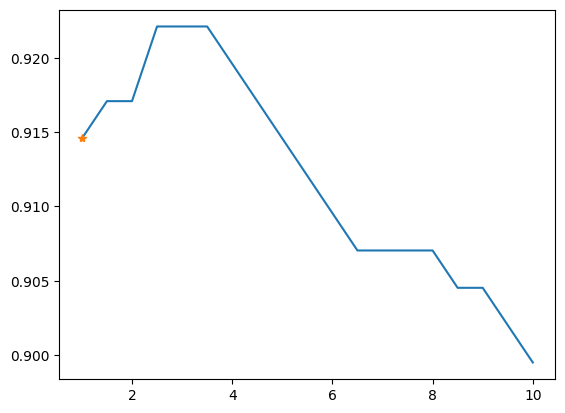

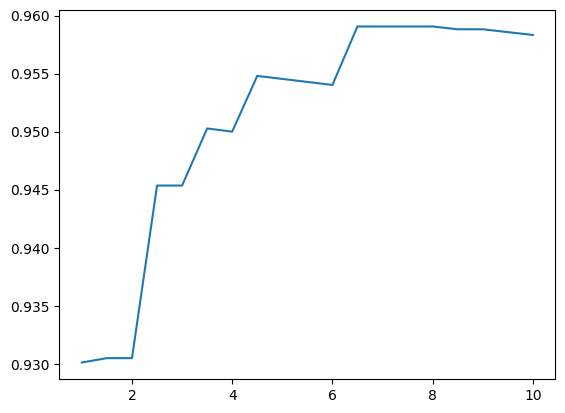

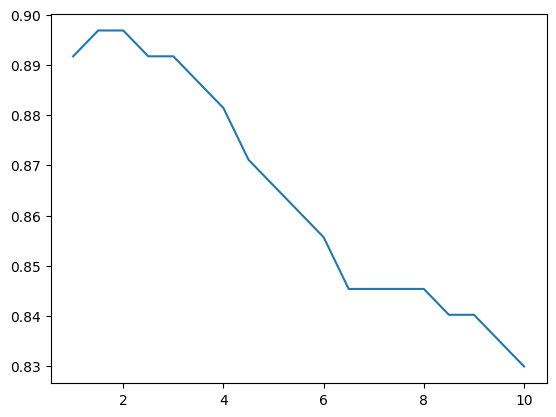

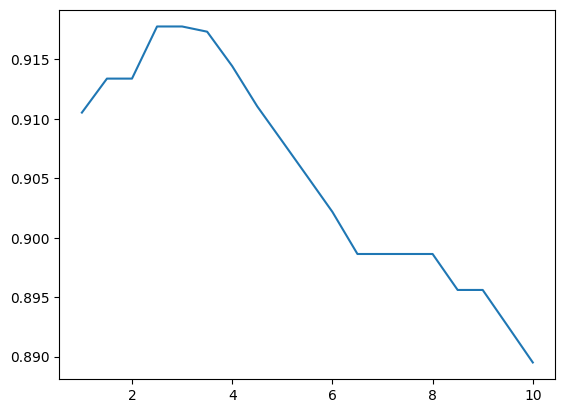

In [44]:
import matplotlib.pyplot as plt
plt.figure("Figure 1")
plt.plot(np.linspace(1, 10, 19), scaled_accs)
plt.plot(1, accs[0], '*')

plt.figure("Figure 2")
plt.plot(np.linspace(1, 10, 19), precisions)

plt.figure("Figure 3")
plt.plot(np.linspace(1, 10, 19), recalls)

plt.figure("Figure 4")
plt.plot(np.linspace(1, 10, 19), f1)

In [170]:
from sklearn.manifold import TSNE

labels = []
tokens = []
preds = []

for i in range(len(preds_list[0])):
  tweet = test_tweets[i]
  words = tweet.split()
  pred = preds_list[0][i]
  for word in words:
    if word in vectorizer.tokenizer.word_to_token and word not in labels and word[0]=='#':
      labels.append(word)
      j = vectorizer.tokenizer.word_to_token[word]
      tokens.append(reps_word2vec[j, :])
      preds.append(pred)

# for i in vectorizer.tokenizer.token_to_word:
#   tokens.append(reps_word2vec[i, :])
#   labels.append(vectorizer.tokenizer.token_to_word[i])

tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(np.array(tokens))

In [119]:
print(len(tokens))
print(len(new_values))
print(len(preds))

175
175
175


In [ ]:
# import matplotlib.pyplot as plt
# x = []
# y = []
# for value in new_values:
#     x.append(value[0])
#     y.append(value[1])

# plt.figure(figsize=(16, 16))
# for i in range(len(x)):
#     plt.scatter(x[i],y[i])
#     plt.annotate(labels[i],
#                   xy=(x[i], y[i]),
#                   xytext=(5, 2),
#                   textcoords='offset points',
#                   ha='right',
#                   va='bottom')
# plt.show()
# # tsne_plot(model)

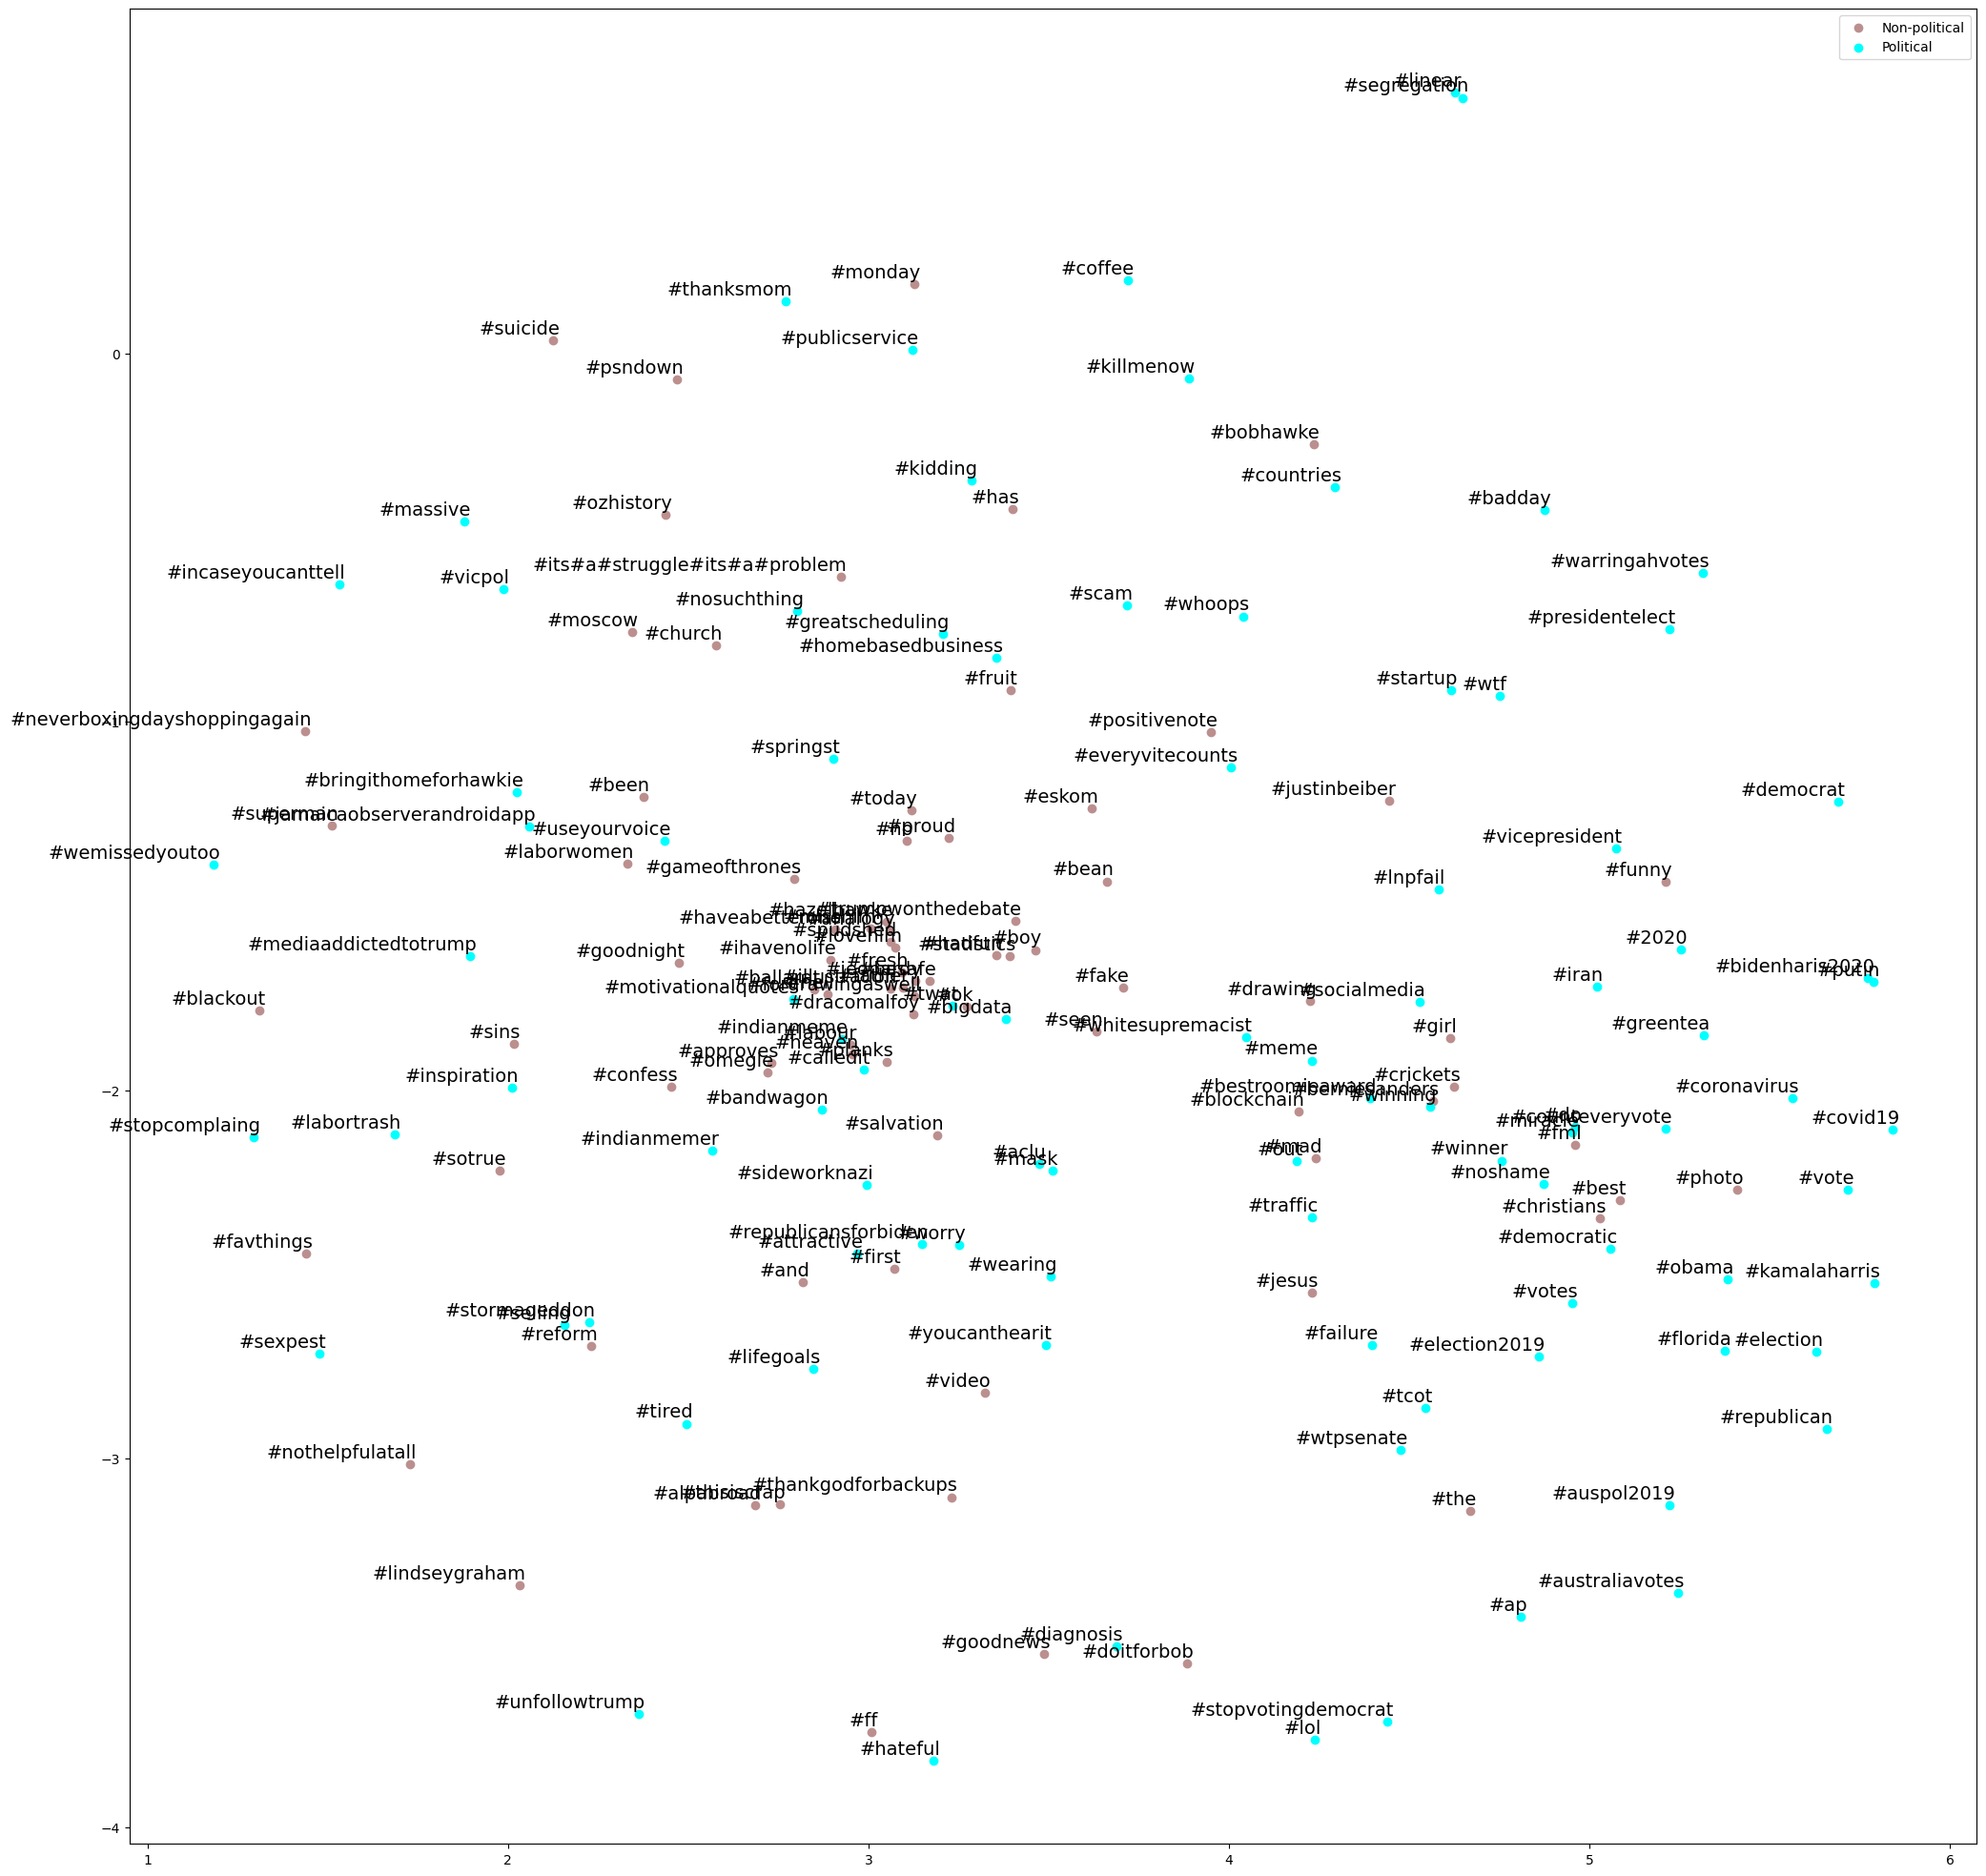

In [171]:
import matplotlib.pyplot as plt
x = []
y = []
colors = {
    0: 'rosybrown',
    1: 'cyan'
}
for value in new_values:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(25, 25))
seen0 = False
seen1 = False
for i in range(len(x)):
    label = 'Political' if preds[i] else 'Non-political'
    if preds[i]:
      label = 'Political'
      if not seen0:
        plt.scatter(x[i],y[i],c=colors[preds[i]], label=label)
        seen0 = True
      else:
        plt.scatter(x[i],y[i],c=colors[preds[i]])
    else:
      label = 'Non-political'
      if not seen1:
        plt.scatter(x[i],y[i],c=colors[preds[i]], label=label)
        seen1 = True
      else:
        plt.scatter(x[i],y[i],c=colors[preds[i]])
    plt.annotate(labels[i],
                  xy=(x[i], y[i]),
                  xytext=(5, 2),
                  textcoords='offset points',
                  ha='right',
                  va='bottom',
                 size=14)
plt.legend()
plt.show()

In [51]:
from sklearn.cluster import KMeans

indices = KMeans(n_clusters=10).fit_predict(reps_word2vec)
zipped = list(zip(range(vectorizer.tokenizer.vocab_size), indices))
np.random.shuffle(zipped)
zipped = zipped[:100]
zipped = sorted(zipped, key=lambda x: x[1], reverse=True)
for token, cluster_idx in zipped:
  word = vectorizer.tokenizer.token_to_word[token]
  print(f"{word}: {cluster_idx}")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


bigotry: 9
fondly: 9
#neveda: 9
western: 9
ubiquitous: 9
church: 9
masculinized: 9
mcpherson: 9
cutting: 9
spying: 9
butler: 9
blu: 9
salivating: 9
built: 8
alice: 7
commissioner: 7
recovery: 7
#red: 7
islamists: 7
#flzjingleball: 7
ive: 7
profile: 7
#greece: 7
#whether: 7
#firsthomeownersvotetoo: 7
blasting: 7
hahahahaha: 7
#impeachamyconeybarrett: 7
#cheat: 7
michigan: 7
#lovecraft: 7
directors: 7
#hasatinyputter: 7
#improved: 7
#statistics: 7
fraser: 7
#mentissues: 7
#monday: 7
#icecream: 7
#perth: 7
gained: 7
manipulating: 7
#votethegopout: 7
#mockingjaypart1: 7
cls: 7
mythical: 7
confused: 7
mizaj: 7
#translivesmatter: 7
definite: 7
#east: 7
#burnout: 7
alike: 7
#washingtondc: 7
mayor: 7
speak: 5
guy: 5
most: 5
knows: 5
music: 5
lines: 4
relevant: 4
choice: 4
kill: 4
#bidenpresident: 4
works: 4
ben: 4
book: 4
vice: 4
color: 4
govt: 4
spend: 4
together: 4
setup: 4
killing: 4
itself: 4
infiniti: 2
comical: 2
#war: 2
tom: 2
executive: 2
birds: 2
sprints: 2
priorities: 2
wishes: 2
cla

In [53]:
words = ["#bidenharris2020"]
show_tokens = [vectorizer.tokenizer.word_to_token[word] for word in words]
show_similar_words(vectorizer.tokenizer, reps_word2vec, show_tokens)

#bidenharris2020 322
  #2020election 1.721
  #bidenharis2020 1.737
  #bidenharris2020tosaveamerica 1.753
  #countallthevotes 1.754
  #electionresults2020 1.760


In [54]:
words = ["#coffee"]
show_tokens = [vectorizer.tokenizer.word_to_token[word] for word in words]
show_similar_words(vectorizer.tokenizer, reps_word2vec, show_tokens)

#coffee 8998
  #accomplishments 1.075
  <s> 1.077
  witter 1.080
  <unk> 1.081
  yeahme 1.086


# RNN

In [13]:
reps_word2vec = torch.tensor(torch.load('naiveword2vec.pt'))

NameError: ignored

In [ ]:
reps_word2vec.shape

In [ ]:
pretrained_embeddings_file = '/content/drive/MyDrive/NLP-Political-Polarity/model/GoogleNews-vectors-negative300.bin'
from gensim.models import Word2Vec, KeyedVectors
import gensim.downloader

# model = gensim.downloader.load('glove-twitter-25')
vectors = KeyedVectors.load_word2vec_format(pretrained_embeddings_file, binary=True)

w2v = Word2Vec(vector_size=300, min_count=1)

# Add the pre-trained model vocabulary
w2v.build_vocab([list(vectors.key_to_index.keys())])

del vectors

w2v

In [ ]:
# Load the pre-trained models embeddings
# note: if a word doesn't exist in the pre-trained vocabulary then it is left as is in the original model
w2v.wv.vectors_lockf = np.ones(len(w2v.wv), dtype=np.float32)
w2v.wv.intersect_word2vec_format(pretrained_embeddings_file, binary=True, lockf=0.0)

w2v

In [ ]:
# Add vocabulary from tweets
def iter_sentences(tweets):
  """need to represent sentences as ['this' 'is', 'a', 'tweet']"""
  for tweet in tweets:
    yield tweet.split()

w2v.build_vocab(iter_sentences(train_tweets+val_tweets+test_tweets+['<pad>','<unk>','<s>','</s>']), update=True)
total_examples = w2v.corpus_count

In [16]:
# Train
w2v.train([tweet.split() for tweet in train_tweets], total_examples=total_examples, epochs=w2v.epochs)

(184077, 213305)

In [17]:
PAD_INDEX = w2v.wv.key_to_index['<pad>']
UNK_INDEX = w2v.wv.key_to_index['<unk>']
SOS_INDEX = w2v.wv.key_to_index['<s>']
EOS_INDEX = w2v.wv.key_to_index['</s>']

In [ ]:
# reps_word2vec = torch.tensor(torch.load('word2vec.pt'))

In [ ]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
rm -rf 68611-hw2

In [ ]:
import os
os.makedirs("68611-hw2", exist_ok=True)
import sys
sys.path.append("/content/68611-hw2")

In [ ]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.4/106.4 kB 2.9 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

device = "cuda" if torch.cuda.is_available() else "cpu"
assert device == "cuda"   # use gpu whenever you can!

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [ ]:
new_vectorizer = CountVectorizer()
new_vectorizer.fit(train_tweets+val_tweets+test_tweets)

In [65]:
print(new_vectorizer.tokenizer.word_to_token)

{'pad': 0, '<unk>': 1, '<s>': 2, '</s>': 3, 'and': 4, 'president': 5, 'neck': 6, '#florida': 7, 'the': 8, 'swing': 9, 'state': 10, 'has': 11, 'electoral': 12, 'votes': 13, 'trump': 14, 'carried': 15, 'florida': 16, 'key': 17, 'that': 18, 'helped': 19, 'deliver': 20, 'presidency': 21, '#maga2020': 22, '#trump2020lanslide': 23, '#floridafortrump': 24, 'whenever': 25, 'write': 26, 'anything': 27, 'with': 28, 'word': 29, 'happy': 30, 'stomach': 31, 'more': 32, 'than': 33, '#hypocrites': 34, 'australia': 35, 'reportedly': 36, 'agreed': 37, 'take': 38, 'rwandan': 39, 'accused': 40, 'murderers': 41, 'refugee': 42, 'deal': 43, 'via': 44, 'franking': 45, 'credit': 46, 'payments': 47, 'indiviuals': 48, 'who': 49, 'pay': 50, 'zero': 51, 'tax': 52, 'not': 53, 'what': 54, 'joke': 55, 'thanks': 56, 'for': 57, 'detailed': 58, 'response': 59, 'communication': 60, 'your': 61, 'customers': 62, 'final': 63, 'episode': 64, '#minecraft': 65, '#hardcore': 66, 'survival': 67, 'die': 68, 'while': 69, 'trying'

In [ ]:
train_tweets_split = []
val_tweets_split = []
test_tweets_split = []
for i in range(len(train_tweets)):
  tweet = train_tweets[i]
  sub_list = []
  sub_list.append(tweet.split())
  sub_list.append(train_labels[i])
  train_tweets_split.append(sub_list)
for i in range(len(val_tweets)):
  tweet = val_tweets[i]
  sub_list = []
  sub_list.append(tweet.split())
  sub_list.append(val_labels[i])
  val_tweets_split.append(sub_list)
for i in range(len(test_tweets)):
  tweet = test_tweets[i]
  sub_list = []
  sub_list.append(tweet.split())
  sub_list.append(test_labels[i])
  test_tweets_split.append(sub_list)
# for tweet in train_tweets:
#   train_tweets_split.append(tweet.split())
# vocab = list(vectorizer.tokenizer.word_to_token.keys())
# vocab.remove('<unk>')
# vocab = ['pad', '<unk>', '<s>', '</s>'] + vocab
# vocab = [v.lower() for v in vocab]

In [ ]:
PAD_INDEX = 0 # w2v.wv.key_to_index['<pad>']
UNK_INDEX = 1 # w2v.wv.key_to_index['<unk>']
SOS_INDEX = 2 # w2v.wv.key_to_index['<s>']
EOS_INDEX = 3 # w2v.wv.key_to_index['</s>']
def texts_to_sequences(tweets):
  sequences = []
  for tweet in tweets:
    split_tweet = tweet.split()
    tweet_seq = []
    for word in split_tweet:
      # if word not in w2v.wv.key_to_index:
      if word not in new_vectorizer.tokenizer.word_to_token:
        tweet_seq.append(UNK_INDEX)
      else:
        tweet_seq.append(new_vectorizer.tokenizer.word_to_token[word])
    sequences.append(tweet_seq)
  return sequences
sequences = texts_to_sequences(train_tweets)
test_sequences = texts_to_sequences(test_tweets)

In [ ]:
max_len = 0
for seq in sequences:
  if len(seq) > max_len:
    max_len = len(seq)
print(max_len)

52


In [ ]:
from torch.utils import data

MAX_SENT_LENGTH = max_len
MAX_SENT_LENGTH_PLUS_SOS_EOS = max_len+2

# These IDs are reserved.
# PAD_INDEX = 0
# UNK_INDEX = 1
# SOS_INDEX = 2
# EOS_INDEX = 3

# class TweetDataset(data.Dataset):
#   def __init__(self, src_sentences, src_vocabs, labels, sampling=1.):
#     self.src_sentences = src_sentences[:int(len(src_sentences) * sampling)]
#     self.labels = labels
#     self.max_src_seq_length = MAX_SENT_LENGTH_PLUS_SOS_EOS

#     self.src_vocabs = src_vocabs

#     self.src_v2id = {v : i for i, v in enumerate(src_vocabs)}
#     self.src_id2v = {val : key for key, val in self.src_v2id.items()}

#   def __len__(self):
#     return len(self.src_sentences)

#   def __getitem__(self, index):
#     sent = self.src_sentences[index]
#     sent_len = len(sent) + 2   # add <s> and </s> to each sentence
#     sent_id = []
#     for w in sent:
#       if w.lower() not in self.src_vocabs:
#         w = '<unk>'
#       sent_id.append(self.src_v2id[w.lower()])
#     src_id = ([SOS_INDEX] + sent_id + [EOS_INDEX] + [PAD_INDEX] *
#               (self.max_src_seq_length - sent_len))
#     trg_id = (sent_id + [EOS_INDEX] + [PAD_INDEX] *
#               (self.max_src_seq_length - sent_len + 1))

#     return torch.tensor(src_id), sent_len, torch.tensor(trg_id), sent_len

In [ ]:
random.shuffle(train_tweets_split)

In [ ]:
def tokenize_sentences(tweets):
  src_ids = []
  for tweet,label in tweets:
    sent_len = len(tweet) + 2   # add <s> and </s> to each sentence
    sent_id = []
    return_list = []
    for w in tweet:
      # if w not in w2v.wv.key_to_index:
      if w not in new_vectorizer.tokenizer.word_to_token:
        w = '<unk>'
      # sent_id.append(w2v.wv.key_to_index[w])
      sent_id.append(new_vectorizer.tokenizer.word_to_token[w])
    src_id = ([SOS_INDEX] + sent_id + [EOS_INDEX] + [PAD_INDEX] *
            (MAX_SENT_LENGTH_PLUS_SOS_EOS - sent_len))
    return_list.append(src_id)
    return_list.append(label)
    src_ids.append(return_list)

  return src_ids

In [ ]:
train_tweets_split = tokenize_sentences(train_tweets_split)
val_tweets_split_pre = tokenize_sentences(val_tweets_split)
test_tweets_split_pre = tokenize_sentences(test_tweets_split)

In [76]:
train_tweets_split[1]

[[2,
  1,
  1888,
  1,
  749,
  139,
  3046,
  1,
  133,
  969,
  430,
  1,
  460,
  1,
  1,
  1,
  311,
  2319,
  96,
  1,
  1,
  121,
  997,
  3,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 1]

In [ ]:
val_tweets_split = []
for i in val_tweets_split_pre:
  if len(i[0]) == MAX_SENT_LENGTH_PLUS_SOS_EOS:
    val_tweets_split.append(i)

In [ ]:
test_tweets_split = []
for i in test_tweets_split_pre:
  if len(i[0]) == MAX_SENT_LENGTH_PLUS_SOS_EOS:
    test_tweets_split.append(i)

In [79]:
print(len(val_tweets_split))

398


In [80]:
print(len(test_tweets_split))

395


In [ ]:
batch_size = 128 # note that this is a hyperparameter you may want to adjust
# print(train_trg_sentences_list[:10])
train_set = []
train_set_labels = []
val_set = []
val_set_labels = []
test_set = []
test_set_labels = []

for i in range(0,len(train_tweets_split),128):
  try:
    batch_tensor = []
    batch_labels = []
    for j in range(batch_size):
      batch_tensor.append(train_tweets_split[i+j][0])
      batch_labels.append(train_tweets_split[i+j][1])
  except:
    pass
  train_set.append(batch_tensor)
  train_set_labels.append(batch_labels)
  # batch_tensor_batch

for i in range(0,len(val_tweets_split),128):
  try:
    batch_tensor = []
    batch_labels = []
    for j in range(batch_size):
      batch_tensor.append(val_tweets_split[i+j][0])
      batch_labels.append(val_tweets_split[i+j][1])
  except:
    pass
  val_set.append(batch_tensor)
  val_set_labels.append(batch_labels)

for i in range(0,len(test_tweets_split),128):
  try:
    batch_tensor = []
    batch_labels = []
    for j in range(batch_size):
      batch_tensor.append(test_tweets_split[i+j][0])
      batch_labels.append(test_tweets_split[i+j][1])
  except:
    pass
  test_set.append(batch_tensor)
  test_set_labels.append(batch_labels)

  # batch_tensor_batch


# train_set = TweetDataset(train_tweets_split, vocab, train_labels, sampling=1.)
# train_data_loader = data.DataLoader(train_set, batch_size=batch_size,
#                                       num_workers=8, shuffle=False)

# val_set = TweetDataset(val_tweets_split, vocab, val_labels, sampling=1.)
# val_data_loader = data.DataLoader(val_set, batch_size=batch_size, num_workers=8,
#                                     shuffle=False)

# # You can try on a smaller training set by setting a smaller `sampling`.
# mt_train_set = MTDataset(train_src_sentences_list, src_vocab_set,
#                         train_trg_sentences_list, trg_vocab_set, sampling=1.)
# mt_train_data_loader = data.DataLoader(mt_train_set, batch_size=batch_size,
#                                       num_workers=8, shuffle=True)

# mt_val_set = MTDataset(val_src_sentences_list, src_vocab_set,
#                       val_trg_sentences_list, trg_vocab_set, sampling=1.)
# mt_val_data_loader = data.DataLoader(mt_val_set, batch_size=batch_size, num_workers=8,
#                                     shuffle=False)

In [ ]:
import math

class SimpleLossCompute:
  """A simple loss compute and train function."""

  def __init__(self, generator, criterion, opt=None):
    self.generator = generator
    self.criterion = criterion
    self.opt = opt

  def __call__(self, x, y, norm):
    x = self.generator(x)
    loss = self.criterion(x,y)
    loss = loss / norm

    if self.opt is not None:  # training mode
      loss.backward()
      self.opt.step()
      self.opt.zero_grad()

    return loss.data.item() * norm

def run_epoch(data, labels, model, loss_compute, task, print_every):
  """Standard Training and Logging Function"""

  total_tokens = 0
  total_loss = 0
  for i in range(len(data)):
    # We define some notations here to help you understand the loaded tensor
    # shapes:
    #   `B`: batch size
    #   `T`: max sequence length of source sentences
    #   `L`: max sequence length of target sentences; due to our preprocessing
    #        in the beginning, `L` == `T` == 50
    # An example of `src_ids_BxT` (when B = 2):
    #   [[2, 4, 6, 7, ..., 4, 3, 0, 0, 0],
    #    [2, 8, 6, 5, ..., 9, 5, 4, 3, 0]]
    # The corresponding `src_lengths_B` would be [47, 49].
    # Note that SOS_INDEX == 2, EOS_INDEX == 3, and PAD_INDEX = 0.

    # src_ids_BxT = src_ids_BxT.to(device)
    # src_lengths_B = src_lengths_B.to(device)
    # trg_ids_BxL = trg_ids_BxL.to(device)
    # del trg_lengths_B   # unused
    output = model(data[i])
    labels_tensor = torch.empty((len(labels[i]), 1)).to(device)
    for j in range(len(labels[i])):
      labels_tensor[j] = labels[i][j]
    loss = loss_compute(x=output, y=labels_tensor,
                      norm=len(data[i]))

    total_loss += loss
    total_tokens += (torch.tensor(data[i]) != PAD_INDEX).data.sum().item()

    if model.training and i % print_every == 0:
      print("Epoch Step: %d Loss: %f" % (i, loss / len(data[i])))
  return total_loss

def train(model, num_epochs, learning_rate, train_data, val_data, train_labels, val_labels, task, print_every):
  # Set `ignore_index` as PAD_INDEX so that pad tokens won't be included when
  # computing the loss.
  criterion = nn.BCELoss(reduction="sum")
  optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

  # Keep track of dev perplexity for each epoch.
  losses = []

  for epoch in range(1, 1+num_epochs):
    print("Epoch", epoch)

    model.train()
    train_loss = run_epoch(data = train_data, labels = train_labels, model=model,
                          loss_compute=SimpleLossCompute(model.generator,
                                                         criterion, optim),
                          task=task,
                          print_every=print_every)

    model.eval()
    with torch.no_grad():
      loss = run_epoch(data=val_data, labels = val_labels, model=model,
                          loss_compute=SimpleLossCompute(model.generator,
                                                         criterion, None),
                          task=task,
                          print_every=print_every)
      print("Validation loss: %f" % loss)
      losses.append(loss)

  return losses

In [ ]:
class RNN(nn.Module):

    def __init__(self, input_size, hidden_size, src_embed, generator, batch_size):
      """
      Inputs:
        - `input_size`: a positive integer corresponding to the size of the
            word embeddings
        - `hidden_size`: a positive integer representing the dimensionality of
            the RNN's hidden state vector
        - `src_embed`: an nn.Embedding object representing the lookup table for
            input (source) sentences
        - `generator`: a `Generator` object. Essentially a linear mapping
            followed by a softmax. You should not call it within this class; it
            is called in the SimpleLossCompute class above
      """
      super(RNN, self).__init__()
      # `input_size`, `hidden_size`, and `output_size` are all int.

      self.hidden_size = hidden_size
      self.src_embed = src_embed
      self.generator = generator
      # self.linear = nn.Linear(in_features=hidden_size, out_features=1)
      # self.sigmoid = nn.Sigmoid()
      # hint: unless you choose to implement the RNN update equations yourself
      #       you will want a `self.rnn` module that does that for you, which
      #       is where the RNNCell/LSTMCell/GRUCell modules come in handy

      ### Your code here! ###
      self.rnn = nn.GRUCell(input_size, hidden_size)
      ###

    def init_hidden(self, batch_size):
      """
      Input:
        - `batch_size`: a positive integer

      Returns:
        - `hidden`: a 2d-tensor of shape (batch_size, hidden_size) representing
            the initial hidden state of the RNN
      """
      # Use to initialize hidden state everytime before running a sentence.
      hidden = torch.zeros(batch_size, self.hidden_size).to(device)
      return hidden

    def forward(self, input_ids):
      """
      Given a sequence of words (represented as IDs), compute and return the
      hidden state at each timestep (equivalently, for each input word).
      Input:
        - `input_ids`: a 2d-tensor of shape
           (batch_size, MAX_SENT_LENGTH_PLUS_SOS_EOS) representing a batch of
           sentences from the dataset (with IDs instead of words)

      Returns:
        - `hiddens`: a 3d-tensor of shape
            (batch_size, MAX_SENT_LENGTH_PLUS_SOS_EOS, hidden_size) representing
            the hidden state of the model at each timestep
      """
      # hint: pay close attention to the shapes of your tensors; you may find
      #       pytorch's `permute()` method for tensors useful

      ### Your code here! ###

      ###

      (batch_size, max_sent_length) = (len(input_ids), len(input_ids[0]))
      input_ids = torch.tensor(input_ids).to(device)
      hx = self.init_hidden(batch_size)
      rnn_out = []
      embeddings = self.src_embed(torch.tensor(input_ids).to(device))
      dummy = torch.Tensor(batch_size, max_sent_length, self.hidden_size)
      for i in range(max_sent_length):
        hx = self.rnn(embeddings[:,i],hx)
        rnn_out.append(hx)
      rnn_out = torch.stack(rnn_out, dim=2)
      # print(rnn_out.shape) # linear head, if output size 1 we need to use sigmoid (binary cross entropy), if output size 2 we can use softmax with cross entropy loss
      hiddens = torch.permute(rnn_out, (0, 2, 1))
      sent_lens = torch.tensor((input_ids != PAD_INDEX)).sum(-1)
      last_positions = [x-1 for x in sent_lens]
      last_hiddens = hiddens[range(hiddens.shape[0]), last_positions]
      # scalar = self.linear(last_hiddens)
      # out = self.sigmoid(scalar)

      return last_hiddens


In [ ]:
class Generator(nn.Module):
  """Define standard linear + softmax generation step."""
  def __init__(self, hidden_size, vocab_size):
    super(Generator, self).__init__()
    self.linear1 = nn.Linear(hidden_size, 128, bias=False)
    self.linear2 = nn.Linear(128, 64, bias=False)
    self.linear3 = nn.Linear(64, 1, bias=False)

  def forward(self, x):
    # lin1 = F.sigmoid(self.proj(x)).to(device)
    lin1 = self.linear1(x)
    lin2 = self.linear2(lin1)
    lin3 = self.linear3(lin2)
    sig = F.sigmoid(lin3).to(device)
    # return 1*(sig >= 0.5)
    return sig

In [35]:
reps = torch.Tensor(w2v.wv.vectors)

In [36]:
reps.shape

torch.Size([3004484, 300])

In [ ]:
len(w2v.wv.key_to_index)

3004581

In [ ]:
embed_size = 256   # Each word will be represented as a `embed_size`-dim vector.
hidden_size = 256

# model itself
rnn_lm = RNN(# input_size = embed_size,
            #  input_size=reps.shape[1],
             input_size = reps_word2vec.shape[1],
             hidden_size=hidden_size,
             src_embed=nn.Embedding(reps_word2vec.shape[0], reps_word2vec.shape[1], _weight=torch.Tensor(reps_word2vec).to(device), _freeze=True),
            #  src_embed=nn.Embedding(len(new_vectorizer.tokenizer.word_to_token), embed_size),
             generator=Generator(hidden_size, len(new_vectorizer.tokenizer.word_to_token)),
             batch_size = batch_size).to(device)

# list of epoch perplexities from training
losses = train(rnn_lm, num_epochs=30,
                    learning_rate=1e-4,
                    train_data=train_set,
                    val_data=val_set,
                    train_labels=train_set_labels,
                    val_labels=val_set_labels,
                    task="lm", print_every=100)

# plot_perplexity(lm_dev_ppls)

Epoch 1
Epoch Step: 0 Loss: 0.692654


<ipython-input-39-7e2ca3ac8b61>:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = self.src_embed(torch.tensor(input_ids).to(device))
<ipython-input-39-7e2ca3ac8b61>:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sent_lens = torch.tensor((input_ids != PAD_INDEX)).sum(-1)


Validation loss: 272.642925
Epoch 2
Epoch Step: 0 Loss: 0.681992
Validation loss: 264.707565
Epoch 3
Epoch Step: 0 Loss: 0.658771
Validation loss: 238.579139
Epoch 4
Epoch Step: 0 Loss: 0.604240
Validation loss: 169.562300
Epoch 5
Epoch Step: 0 Loss: 0.508587
Validation loss: 142.581813
Epoch 6
Epoch Step: 0 Loss: 0.448848
Validation loss: 136.932791
Epoch 7
Epoch Step: 0 Loss: 0.447548
Validation loss: 135.407291
Epoch 8
Epoch Step: 0 Loss: 0.441263
Validation loss: 136.682571
Epoch 9
Epoch Step: 0 Loss: 0.445283
Validation loss: 139.704302
Epoch 10
Epoch Step: 0 Loss: 0.455306
Validation loss: 140.248882
Epoch 11
Epoch Step: 0 Loss: 0.450250
Validation loss: 135.092011
Epoch 12
Epoch Step: 0 Loss: 0.421232
Validation loss: 130.714143
Epoch 13
Epoch Step: 0 Loss: 0.396731
Validation loss: 129.044206
Epoch 14
Epoch Step: 0 Loss: 0.384756
Validation loss: 128.594386
Epoch 15
Epoch Step: 0 Loss: 0.377972
Validation loss: 128.466666
Epoch 16
Epoch Step: 0 Loss: 0.371890
Validation loss: 1

Text(0, 0.5, 'Loss')

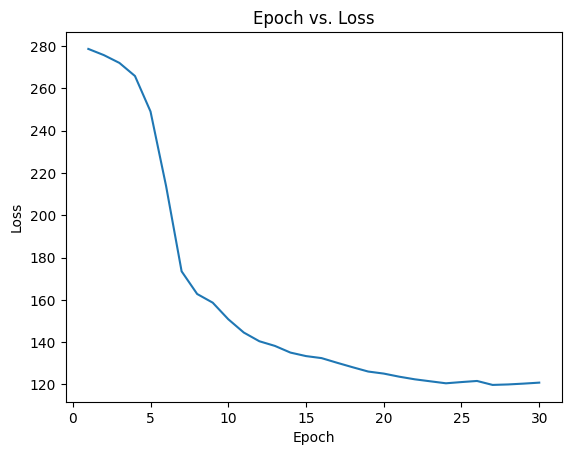

In [124]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(range(1,31), losses)
plt.title('Epoch vs. Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
# gen = Generator(hidden_size, len(w2v.wv.key_to_index)).to(device)
gen = Generator(hidden_size, len(new_vectorizer.tokenizer.word_to_token)).to(device)
accs1 = []
recs1 = []
prec1 = []
f1s1 = []
sigs1 = []
for i in range(len(test_set)):
  outs = rnn_lm(test_set[i]).to(device)
  sig = (1*(gen(outs)>=0.5)).cpu().numpy()
  sigs1.append(sig)
  accs1.append(np.mean(sig==test_set_labels[i]))
  # print(np.mean(sig==test_set_labels[i]))
  recs1.append(sklearn.metrics.recall_score(test_set_labels[i], sig))
  prec1.append(sklearn.metrics.precision_score(test_set_labels[i], sig))
  f1s1.append(sklearn.metrics.f1_score(test_set_labels[i], sig))

<ipython-input-39-7e2ca3ac8b61>:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = self.src_embed(torch.tensor(input_ids).to(device))
<ipython-input-39-7e2ca3ac8b61>:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sent_lens = torch.tensor((input_ids != PAD_INDEX)).sum(-1)
<ipython-input-39-7e2ca3ac8b61>:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = self.src_embed(torch.tensor(input_ids).to(device))
<ipython-input-39-7e2ca3ac8b61>:78: UserWarning: To copy construct from a tensor, it is recommended to use sour

In [ ]:
flattened_sigs = []
flattened_labels = []
flattened_test_tweets = []
for sublist in sigs1:
  for out in sublist:
    flattened_sigs.append(out[0])
for sublist in test_set_labels:
  for out in sublist:
    flattened_labels.append(out)
for sublist in test_set:
  for out in sublist:
    flattened_test_tweets.append(out)

In [ ]:
def is_hashtag(word):
  return word[0] == '#'

def scale_reps(weights, scale_factor):
    """D x len(s) => D x E"""
    scaled_weights = weights
    # hashtagged_words = {k: v for k, v in w2v.wv.key_to_index.items() if k[0]=='#'}

    for word in new_vectorizer.tokenizer.word_to_token:
      if word[0] == '#':
        idx = new_vectorizer.tokenizer.word_to_token[word]
        scaled_weights[idx] = scaled_weights[idx] * scale_factor

    return scaled_weights

    # for idx, tweet in enumerate(xs):
    #   total_embedding = np.zeros((embed_dim,))

    #   for word in tweet:

    #       if not word in w2v.wv:
    #         continue  # treat embedding as the 0 vector

    #       word_embedding = w2v.wv.get_vector(word)

    #       # Scale hashtag words
    #       if is_hashtag(word):
    #         word_embedding = scale_factor * word_embedding

    #       total_embedding += word_embedding

    #   feats[idx] = total_embedding

    # # normalize
    # feats = feats / np.sqrt((feats ** 2).sum(axis=1, keepdims=True))
    # for i in range(len(feats)):
    #   if np.any(np.isnan(feats[i])):
    #     feats[i] = np.zeros(embed_dim)
    # return feats

scaled_accs = []
scaled_prec = []
scaled_recs = []
scaled_f1s = []
scaled_preds_list = []
for factor in np.linspace(1,10,num=19):
  print(f'======= RNN Experiment w/ {factor=} =======')
  scaled_reps = scale_reps(reps_word2vec, factor)
  rnn_lm = RNN(#input_size = embed_size,
             input_size=scaled_reps.shape[1],
             hidden_size=hidden_size,
             src_embed=nn.Embedding(scaled_reps.shape[0], scaled_reps.shape[1], _weight=torch.Tensor(scaled_reps).to(device), _freeze=True),
            #  src_embed=nn.Embedding(len(new_vectorizer.tokenizer.word_to_token), embed_size),
             generator=Generator(hidden_size, len(new_vectorizer.tokenizer.word_to_token)),
             batch_size = batch_size).to(device)

  # # list of epoch perplexities from training
  losses = train(rnn_lm, num_epochs=30,
                      learning_rate=1e-4,
                      train_data=train_set,
                      val_data=val_set,
                      train_labels=train_set_labels,
                      val_labels=val_set_labels,
                      task="lm", print_every=100)

  # # plot losses
  # import matplotlib.pyplot as plt
  # plt.figure()
  # plt.plot(range(1,31), losses)
  # plt.title('Epoch vs. Loss')
  # plt.xlabel('Epoch')
  # plt.ylabel('Loss')

  # get sigmoid outputs
  gen = Generator(hidden_size, len(new_vectorizer.tokenizer.word_to_token)).to(device)
  accs = []
  recs = []
  prec = []
  f1s = []
  for i in range(len(test_set)):
    outs = rnn_lm(test_set[i]).to(device)
    sig = (1*(gen(outs)>=0.5)).cpu().numpy()
    accs.append(np.mean(sig==test_set_labels[i]))
    # print(np.mean(sig==test_set_labels[i]))
    recs.append(sklearn.metrics.recall_score(test_set_labels[i], sig))
    prec.append(sklearn.metrics.precision_score(test_set_labels[i], sig))
    f1s.append(sklearn.metrics.f1_score(test_set_labels[i], sig))
  scaled_accs.append(np.mean(accs))
  scaled_recs.append(np.mean(recs))
  scaled_prec.append(np.mean(prec))
  scaled_f1s.append(np.mean(f1s))

======= RNN Experiment w/ factor=1.0 =======
Epoch 1


<ipython-input-39-7e2ca3ac8b61>:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = self.src_embed(torch.tensor(input_ids).to(device))
<ipython-input-39-7e2ca3ac8b61>:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sent_lens = torch.tensor((input_ids != PAD_INDEX)).sum(-1)


Epoch Step: 0 Loss: 0.692833
Validation loss: 272.452729
Epoch 2
Epoch Step: 0 Loss: 0.681019
Validation loss: 263.763867
Epoch 3
Epoch Step: 0 Loss: 0.655671
Validation loss: 235.000037
Epoch 4
Epoch Step: 0 Loss: 0.595148
Validation loss: 163.976719
Epoch 5
Epoch Step: 0 Loss: 0.503048
Validation loss: 139.364822
Epoch 6
Epoch Step: 0 Loss: 0.447769
Validation loss: 136.157811
Epoch 7
Epoch Step: 0 Loss: 0.452749
Validation loss: 135.759707
Epoch 8
Epoch Step: 0 Loss: 0.450218
Validation loss: 137.653687
Epoch 9
Epoch Step: 0 Loss: 0.454562
Validation loss: 138.600682
Epoch 10
Epoch Step: 0 Loss: 0.453306
Validation loss: 135.261077
Epoch 11
Epoch Step: 0 Loss: 0.431816
Validation loss: 130.883095
Epoch 12
Epoch Step: 0 Loss: 0.406326
Validation loss: 128.561392
Epoch 13
Epoch Step: 0 Loss: 0.390750
Validation loss: 127.633387
Epoch 14
Epoch Step: 0 Loss: 0.381570
Validation loss: 127.215537
Epoch 15
Epoch Step: 0 Loss: 0.374244
Validation loss: 126.959861
Epoch 16
Epoch Step: 0 Loss

<ipython-input-39-7e2ca3ac8b61>:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = self.src_embed(torch.tensor(input_ids).to(device))
<ipython-input-39-7e2ca3ac8b61>:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sent_lens = torch.tensor((input_ids != PAD_INDEX)).sum(-1)
<ipython-input-39-7e2ca3ac8b61>:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = self.src_embed(torch.tensor(input_ids).to(device))
<ipython-input-39-7e2ca3ac8b61>:78: UserWarning: To copy construct from a tensor, it is recommended to use sour

Validation loss: 272.179942
Epoch 2
Epoch Step: 0 Loss: 0.679486
Validation loss: 262.794593
Epoch 3
Epoch Step: 0 Loss: 0.652348
Validation loss: 232.337972
Epoch 4
Epoch Step: 0 Loss: 0.587595
Validation loss: 158.751243
Epoch 5
Epoch Step: 0 Loss: 0.496014
Validation loss: 136.614971
Epoch 6
Epoch Step: 0 Loss: 0.443496
Validation loss: 134.559433
Epoch 7
Epoch Step: 0 Loss: 0.441781
Validation loss: 134.008715
Epoch 8
Epoch Step: 0 Loss: 0.438562
Validation loss: 136.370760
Epoch 9
Epoch Step: 0 Loss: 0.445742
Validation loss: 139.241294
Epoch 10
Epoch Step: 0 Loss: 0.453555
Validation loss: 137.899092
Epoch 11
Epoch Step: 0 Loss: 0.441484
Validation loss: 133.256614
Epoch 12
Epoch Step: 0 Loss: 0.415794
Validation loss: 130.047294
Epoch 13
Epoch Step: 0 Loss: 0.397001
Validation loss: 128.673106
Epoch 14
Epoch Step: 0 Loss: 0.386777
Validation loss: 128.106245
Epoch 15
Epoch Step: 0 Loss: 0.380009
Validation loss: 127.781255
Epoch 16
Epoch Step: 0 Loss: 0.373846
Validation loss: 1

<ipython-input-39-7e2ca3ac8b61>:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = self.src_embed(torch.tensor(input_ids).to(device))
<ipython-input-39-7e2ca3ac8b61>:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sent_lens = torch.tensor((input_ids != PAD_INDEX)).sum(-1)
<ipython-input-39-7e2ca3ac8b61>:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = self.src_embed(torch.tensor(input_ids).to(device))
<ipython-input-39-7e2ca3ac8b61>:78: UserWarning: To copy construct from a tensor, it is recommended to use sour

Validation loss: 273.343302
Epoch 2
Epoch Step: 0 Loss: 0.683154
Validation loss: 265.957411
Epoch 3
Epoch Step: 0 Loss: 0.660367
Validation loss: 236.829022
Epoch 4
Epoch Step: 0 Loss: 0.599414
Validation loss: 157.375478
Epoch 5
Epoch Step: 0 Loss: 0.482888
Validation loss: 140.322315
Epoch 6
Epoch Step: 0 Loss: 0.442197
Validation loss: 137.881283
Epoch 7
Epoch Step: 0 Loss: 0.441207
Validation loss: 136.834901
Epoch 8
Epoch Step: 0 Loss: 0.435100
Validation loss: 138.707931
Epoch 9
Epoch Step: 0 Loss: 0.441199
Validation loss: 141.055707
Epoch 10
Epoch Step: 0 Loss: 0.448928
Validation loss: 139.272974
Epoch 11
Epoch Step: 0 Loss: 0.437184
Validation loss: 134.514674
Epoch 12
Epoch Step: 0 Loss: 0.412742
Validation loss: 130.935308
Epoch 13
Epoch Step: 0 Loss: 0.393986
Validation loss: 128.855196
Epoch 14
Epoch Step: 0 Loss: 0.382241
Validation loss: 127.543485
Epoch 15
Epoch Step: 0 Loss: 0.373756
Validation loss: 126.549732
Epoch 16
Epoch Step: 0 Loss: 0.366175
Validation loss: 1

<ipython-input-39-7e2ca3ac8b61>:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = self.src_embed(torch.tensor(input_ids).to(device))
<ipython-input-39-7e2ca3ac8b61>:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sent_lens = torch.tensor((input_ids != PAD_INDEX)).sum(-1)
<ipython-input-39-7e2ca3ac8b61>:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = self.src_embed(torch.tensor(input_ids).to(device))
<ipython-input-39-7e2ca3ac8b61>:78: UserWarning: To copy construct from a tensor, it is recommended to use sour

Validation loss: 274.153057
Epoch 2
Epoch Step: 0 Loss: 0.686132
Validation loss: 268.474614
Epoch 3
Epoch Step: 0 Loss: 0.669735
Validation loss: 242.109130
Epoch 4
Epoch Step: 0 Loss: 0.613036
Validation loss: 160.058112
Epoch 5
Epoch Step: 0 Loss: 0.477071
Validation loss: 148.134765
Epoch 6
Epoch Step: 0 Loss: 0.452194
Validation loss: 147.019547
Epoch 7
Epoch Step: 0 Loss: 0.451717
Validation loss: 147.747583
Epoch 8
Epoch Step: 0 Loss: 0.458364
Validation loss: 147.948429
Epoch 9
Epoch Step: 0 Loss: 0.461882
Validation loss: 142.312111
Epoch 10
Epoch Step: 0 Loss: 0.439516
Validation loss: 134.702858
Epoch 11
Epoch Step: 0 Loss: 0.408890
Validation loss: 130.219942
Epoch 12
Epoch Step: 0 Loss: 0.392140
Validation loss: 127.690737
Epoch 13
Epoch Step: 0 Loss: 0.382598
Validation loss: 125.740397
Epoch 14
Epoch Step: 0 Loss: 0.374077
Validation loss: 124.109384
Epoch 15
Epoch Step: 0 Loss: 0.365911
Validation loss: 122.754745
Epoch 16
Epoch Step: 0 Loss: 0.357975
Validation loss: 1

<ipython-input-39-7e2ca3ac8b61>:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = self.src_embed(torch.tensor(input_ids).to(device))
<ipython-input-39-7e2ca3ac8b61>:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sent_lens = torch.tensor((input_ids != PAD_INDEX)).sum(-1)
<ipython-input-39-7e2ca3ac8b61>:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = self.src_embed(torch.tensor(input_ids).to(device))
<ipython-input-39-7e2ca3ac8b61>:78: UserWarning: To copy construct from a tensor, it is recommended to use sour

Validation loss: 273.801730
Epoch 2
Epoch Step: 0 Loss: 0.687664
Validation loss: 268.812037
Epoch 3
Epoch Step: 0 Loss: 0.675636
Validation loss: 251.824474
Epoch 4
Epoch Step: 0 Loss: 0.635241
Validation loss: 209.884941
Epoch 5
Epoch Step: 0 Loss: 0.562685
Validation loss: 159.168668
Epoch 6
Epoch Step: 0 Loss: 0.456547
Validation loss: 139.198118
Epoch 7
Epoch Step: 0 Loss: 0.403029
Validation loss: 130.448622
Epoch 8
Epoch Step: 0 Loss: 0.382162
Validation loss: 124.581198
Epoch 9
Epoch Step: 0 Loss: 0.368138
Validation loss: 121.357994
Epoch 10
Epoch Step: 0 Loss: 0.361399
Validation loss: 117.337105
Epoch 11
Epoch Step: 0 Loss: 0.345999
Validation loss: 116.080120
Epoch 12
Epoch Step: 0 Loss: 0.342310
Validation loss: 112.729428
Epoch 13
Epoch Step: 0 Loss: 0.324239
Validation loss: 111.400366
Epoch 14
Epoch Step: 0 Loss: 0.317280
Validation loss: 109.179550
Epoch 15
Epoch Step: 0 Loss: 0.302708
Validation loss: 107.685690
Epoch 16
Epoch Step: 0 Loss: 0.293133
Validation loss: 1

<ipython-input-39-7e2ca3ac8b61>:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = self.src_embed(torch.tensor(input_ids).to(device))
<ipython-input-39-7e2ca3ac8b61>:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sent_lens = torch.tensor((input_ids != PAD_INDEX)).sum(-1)
<ipython-input-39-7e2ca3ac8b61>:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = self.src_embed(torch.tensor(input_ids).to(device))
<ipython-input-39-7e2ca3ac8b61>:78: UserWarning: To copy construct from a tensor, it is recommended to use sour

Validation loss: 272.150565
Epoch 2
Epoch Step: 0 Loss: 0.683419
Validation loss: 266.845683
Epoch 3
Epoch Step: 0 Loss: 0.670759
Validation loss: 253.435682
Epoch 4
Epoch Step: 0 Loss: 0.633009
Validation loss: 225.214025
Epoch 5
Epoch Step: 0 Loss: 0.560385
Validation loss: 174.507123
Epoch 6
Epoch Step: 0 Loss: 0.466636
Validation loss: 147.499564
Epoch 7
Epoch Step: 0 Loss: 0.402022
Validation loss: 135.234648
Epoch 8
Epoch Step: 0 Loss: 0.370844
Validation loss: 130.061922
Epoch 9
Epoch Step: 0 Loss: 0.352984
Validation loss: 127.373013
Epoch 10
Epoch Step: 0 Loss: 0.335125
Validation loss: 124.987891
Epoch 11
Epoch Step: 0 Loss: 0.316996
Validation loss: 122.265410
Epoch 12
Epoch Step: 0 Loss: 0.301091
Validation loss: 120.736458
Epoch 13
Epoch Step: 0 Loss: 0.285490
Validation loss: 119.549855
Epoch 14
Epoch Step: 0 Loss: 0.270250
Validation loss: 119.307790
Epoch 15
Epoch Step: 0 Loss: 0.255148
Validation loss: 119.689816
Epoch 16
Epoch Step: 0 Loss: 0.240310
Validation loss: 1

<ipython-input-39-7e2ca3ac8b61>:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = self.src_embed(torch.tensor(input_ids).to(device))
<ipython-input-39-7e2ca3ac8b61>:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sent_lens = torch.tensor((input_ids != PAD_INDEX)).sum(-1)
<ipython-input-39-7e2ca3ac8b61>:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = self.src_embed(torch.tensor(input_ids).to(device))
<ipython-input-39-7e2ca3ac8b61>:78: UserWarning: To copy construct from a tensor, it is recommended to use sour

Validation loss: 273.237668
Epoch 2
Epoch Step: 0 Loss: 0.681921
Validation loss: 269.678294
Epoch 3
Epoch Step: 0 Loss: 0.670696
Validation loss: 260.842658
Epoch 4
Epoch Step: 0 Loss: 0.640794
Validation loss: 239.241787
Epoch 5
Epoch Step: 0 Loss: 0.575649
Validation loss: 190.709233
Epoch 6
Epoch Step: 0 Loss: 0.471364
Validation loss: 159.049794
Epoch 7
Epoch Step: 0 Loss: 0.395390
Validation loss: 151.393312
Epoch 8
Epoch Step: 0 Loss: 0.363724
Validation loss: 143.240412
Epoch 9
Epoch Step: 0 Loss: 0.350130
Validation loss: 141.617679
Epoch 10
Epoch Step: 0 Loss: 0.332006
Validation loss: 140.082102
Epoch 11
Epoch Step: 0 Loss: 0.314011
Validation loss: 138.965058
Epoch 12
Epoch Step: 0 Loss: 0.298264
Validation loss: 140.869516
Epoch 13
Epoch Step: 0 Loss: 0.282776
Validation loss: 143.151899
Epoch 14
Epoch Step: 0 Loss: 0.267342
Validation loss: 146.069478
Epoch 15
Epoch Step: 0 Loss: 0.251880
Validation loss: 150.200304
Epoch 16
Epoch Step: 0 Loss: 0.236347
Validation loss: 1

<ipython-input-39-7e2ca3ac8b61>:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = self.src_embed(torch.tensor(input_ids).to(device))
<ipython-input-39-7e2ca3ac8b61>:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sent_lens = torch.tensor((input_ids != PAD_INDEX)).sum(-1)
<ipython-input-39-7e2ca3ac8b61>:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = self.src_embed(torch.tensor(input_ids).to(device))
<ipython-input-39-7e2ca3ac8b61>:78: UserWarning: To copy construct from a tensor, it is recommended to use sour

Validation loss: 274.763582
Epoch 2
Epoch Step: 0 Loss: 0.685731
Validation loss: 272.151139
Epoch 3
Epoch Step: 0 Loss: 0.678503
Validation loss: 267.190920
Epoch 4
Epoch Step: 0 Loss: 0.659502
Validation loss: 253.630673
Epoch 5
Epoch Step: 0 Loss: 0.615803
Validation loss: 215.232106
Epoch 6
Epoch Step: 0 Loss: 0.525225
Validation loss: 171.438248
Epoch 7
Epoch Step: 0 Loss: 0.433782
Validation loss: 159.180155
Epoch 8
Epoch Step: 0 Loss: 0.389441
Validation loss: 153.668165
Epoch 9
Epoch Step: 0 Loss: 0.378746
Validation loss: 151.905072
Epoch 10
Epoch Step: 0 Loss: 0.364264
Validation loss: 146.359625
Epoch 11
Epoch Step: 0 Loss: 0.351076
Validation loss: 146.567318
Epoch 12
Epoch Step: 0 Loss: 0.339229
Validation loss: 145.831368
Epoch 13
Epoch Step: 0 Loss: 0.327126
Validation loss: 144.883063
Epoch 14
Epoch Step: 0 Loss: 0.314924
Validation loss: 145.014820
Epoch 15
Epoch Step: 0 Loss: 0.302772
Validation loss: 145.816714
Epoch 16
Epoch Step: 0 Loss: 0.290405
Validation loss: 1

<ipython-input-39-7e2ca3ac8b61>:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = self.src_embed(torch.tensor(input_ids).to(device))
<ipython-input-39-7e2ca3ac8b61>:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sent_lens = torch.tensor((input_ids != PAD_INDEX)).sum(-1)
<ipython-input-39-7e2ca3ac8b61>:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = self.src_embed(torch.tensor(input_ids).to(device))
<ipython-input-39-7e2ca3ac8b61>:78: UserWarning: To copy construct from a tensor, it is recommended to use sour

Validation loss: 274.879638
Epoch 2
Epoch Step: 0 Loss: 0.686533
Validation loss: 272.276500
Epoch 3
Epoch Step: 0 Loss: 0.679851
Validation loss: 267.579041
Epoch 4
Epoch Step: 0 Loss: 0.669550
Validation loss: 253.968611
Epoch 5
Epoch Step: 0 Loss: 0.634779
Validation loss: 215.557974
Epoch 6
Epoch Step: 0 Loss: 0.572316
Validation loss: 172.869424
Epoch 7
Epoch Step: 0 Loss: 0.495781
Validation loss: 164.450533
Epoch 8
Epoch Step: 0 Loss: 0.475097
Validation loss: 160.652399
Epoch 9
Epoch Step: 0 Loss: 0.474765
Validation loss: 150.882864
Epoch 10
Epoch Step: 0 Loss: 0.438405
Validation loss: 142.323101
Epoch 11
Epoch Step: 0 Loss: 0.410649
Validation loss: 135.854531
Epoch 12
Epoch Step: 0 Loss: 0.391710
Validation loss: 134.233468
Epoch 13
Epoch Step: 0 Loss: 0.374213
Validation loss: 132.886117
Epoch 14
Epoch Step: 0 Loss: 0.366595
Validation loss: 132.319755
Epoch 15
Epoch Step: 0 Loss: 0.355808
Validation loss: 128.606475
Epoch 16
Epoch Step: 0 Loss: 0.347097
Validation loss: 1

<ipython-input-39-7e2ca3ac8b61>:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = self.src_embed(torch.tensor(input_ids).to(device))
<ipython-input-39-7e2ca3ac8b61>:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sent_lens = torch.tensor((input_ids != PAD_INDEX)).sum(-1)
<ipython-input-39-7e2ca3ac8b61>:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = self.src_embed(torch.tensor(input_ids).to(device))
<ipython-input-39-7e2ca3ac8b61>:78: UserWarning: To copy construct from a tensor, it is recommended to use sour

Validation loss: 276.224964
Epoch 2
Epoch Step: 0 Loss: 0.689218
Validation loss: 273.994949
Epoch 3
Epoch Step: 0 Loss: 0.684567
Validation loss: 269.782372
Epoch 4
Epoch Step: 0 Loss: 0.673959
Validation loss: 258.823303
Epoch 5
Epoch Step: 0 Loss: 0.649718
Validation loss: 230.136904
Epoch 6
Epoch Step: 0 Loss: 0.596133
Validation loss: 182.471103
Epoch 7
Epoch Step: 0 Loss: 0.519152
Validation loss: 176.732991
Epoch 8
Epoch Step: 0 Loss: 0.522222
Validation loss: 171.680465
Epoch 9
Epoch Step: 0 Loss: 0.498286
Validation loss: 157.049647
Epoch 10
Epoch Step: 0 Loss: 0.438749
Validation loss: 150.928162
Epoch 11
Epoch Step: 0 Loss: 0.425987
Validation loss: 145.467885
Epoch 12
Epoch Step: 0 Loss: 0.421829
Validation loss: 142.176969
Epoch 13
Epoch Step: 0 Loss: 0.409416
Validation loss: 138.817857
Epoch 14
Epoch Step: 0 Loss: 0.402414
Validation loss: 137.066752
Epoch 15
Epoch Step: 0 Loss: 0.393419
Validation loss: 136.849666
Epoch 16
Epoch Step: 0 Loss: 0.392209
Validation loss: 1

<ipython-input-39-7e2ca3ac8b61>:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = self.src_embed(torch.tensor(input_ids).to(device))
<ipython-input-39-7e2ca3ac8b61>:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sent_lens = torch.tensor((input_ids != PAD_INDEX)).sum(-1)
<ipython-input-39-7e2ca3ac8b61>:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = self.src_embed(torch.tensor(input_ids).to(device))
<ipython-input-39-7e2ca3ac8b61>:78: UserWarning: To copy construct from a tensor, it is recommended to use sour

Validation loss: 276.833504
Epoch 2
Epoch Step: 0 Loss: 0.688904
Validation loss: 274.820395
Epoch 3
Epoch Step: 0 Loss: 0.683519
Validation loss: 271.535192
Epoch 4
Epoch Step: 0 Loss: 0.673176
Validation loss: 262.663417
Epoch 5
Epoch Step: 0 Loss: 0.648449
Validation loss: 233.195336
Epoch 6
Epoch Step: 0 Loss: 0.593007
Validation loss: 187.501725
Epoch 7
Epoch Step: 0 Loss: 0.520958
Validation loss: 186.442164
Epoch 8
Epoch Step: 0 Loss: 0.530410
Validation loss: 179.598519
Epoch 9
Epoch Step: 0 Loss: 0.508303
Validation loss: 165.650602
Epoch 10
Epoch Step: 0 Loss: 0.449873
Validation loss: 161.399611
Epoch 11
Epoch Step: 0 Loss: 0.437740
Validation loss: 159.826142
Epoch 12
Epoch Step: 0 Loss: 0.437078
Validation loss: 156.333943
Epoch 13
Epoch Step: 0 Loss: 0.426710
Validation loss: 153.734344
Epoch 14
Epoch Step: 0 Loss: 0.406920
Validation loss: 151.034146
Epoch 15
Epoch Step: 0 Loss: 0.402011
Validation loss: 148.272177
Epoch 16
Epoch Step: 0 Loss: 0.390177
Validation loss: 1

<ipython-input-39-7e2ca3ac8b61>:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = self.src_embed(torch.tensor(input_ids).to(device))
<ipython-input-39-7e2ca3ac8b61>:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sent_lens = torch.tensor((input_ids != PAD_INDEX)).sum(-1)
<ipython-input-39-7e2ca3ac8b61>:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = self.src_embed(torch.tensor(input_ids).to(device))
<ipython-input-39-7e2ca3ac8b61>:78: UserWarning: To copy construct from a tensor, it is recommended to use sour

Validation loss: 277.171283
Epoch 2
Epoch Step: 0 Loss: 0.689862
Validation loss: 275.121962
Epoch 3
Epoch Step: 0 Loss: 0.685024
Validation loss: 271.691861
Epoch 4
Epoch Step: 0 Loss: 0.677090
Validation loss: 263.444318
Epoch 5
Epoch Step: 0 Loss: 0.655535
Validation loss: 238.468350
Epoch 6
Epoch Step: 0 Loss: 0.606988
Validation loss: 191.820801
Epoch 7
Epoch Step: 0 Loss: 0.538015
Validation loss: 182.448003
Epoch 8
Epoch Step: 0 Loss: 0.522470
Validation loss: 178.795392
Epoch 9
Epoch Step: 0 Loss: 0.514917
Validation loss: 165.171524
Epoch 10
Epoch Step: 0 Loss: 0.462391
Validation loss: 157.719333
Epoch 11
Epoch Step: 0 Loss: 0.441250
Validation loss: 154.890162
Epoch 12
Epoch Step: 0 Loss: 0.434476
Validation loss: 152.664752
Epoch 13
Epoch Step: 0 Loss: 0.421396
Validation loss: 150.523300
Epoch 14
Epoch Step: 0 Loss: 0.416591
Validation loss: 147.125618
Epoch 15
Epoch Step: 0 Loss: 0.405106
Validation loss: 145.750042
Epoch 16
Epoch Step: 0 Loss: 0.395127
Validation loss: 1

<ipython-input-39-7e2ca3ac8b61>:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = self.src_embed(torch.tensor(input_ids).to(device))
<ipython-input-39-7e2ca3ac8b61>:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sent_lens = torch.tensor((input_ids != PAD_INDEX)).sum(-1)
<ipython-input-39-7e2ca3ac8b61>:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = self.src_embed(torch.tensor(input_ids).to(device))
<ipython-input-39-7e2ca3ac8b61>:78: UserWarning: To copy construct from a tensor, it is recommended to use sour

Validation loss: 277.575499
Epoch 2
Epoch Step: 0 Loss: 0.689370
Validation loss: 275.640684
Epoch 3
Epoch Step: 0 Loss: 0.685708
Validation loss: 272.316124
Epoch 4
Epoch Step: 0 Loss: 0.678407
Validation loss: 265.102638
Epoch 5
Epoch Step: 0 Loss: 0.660117
Validation loss: 244.128851
Epoch 6
Epoch Step: 0 Loss: 0.614833
Validation loss: 208.341686
Epoch 7
Epoch Step: 0 Loss: 0.570402
Validation loss: 188.198845
Epoch 8
Epoch Step: 0 Loss: 0.522867
Validation loss: 179.312872
Epoch 9
Epoch Step: 0 Loss: 0.502299
Validation loss: 169.889303
Epoch 10
Epoch Step: 0 Loss: 0.477073
Validation loss: 162.033436
Epoch 11
Epoch Step: 0 Loss: 0.450995
Validation loss: 159.673576
Epoch 12
Epoch Step: 0 Loss: 0.454827
Validation loss: 155.651361
Epoch 13
Epoch Step: 0 Loss: 0.439072
Validation loss: 151.355611
Epoch 14
Epoch Step: 0 Loss: 0.421275
Validation loss: 149.224366
Epoch 15
Epoch Step: 0 Loss: 0.411667
Validation loss: 146.373741
Epoch 16
Epoch Step: 0 Loss: 0.400866
Validation loss: 1

<ipython-input-39-7e2ca3ac8b61>:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = self.src_embed(torch.tensor(input_ids).to(device))
<ipython-input-39-7e2ca3ac8b61>:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sent_lens = torch.tensor((input_ids != PAD_INDEX)).sum(-1)
<ipython-input-39-7e2ca3ac8b61>:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = self.src_embed(torch.tensor(input_ids).to(device))
<ipython-input-39-7e2ca3ac8b61>:78: UserWarning: To copy construct from a tensor, it is recommended to use sour

Validation loss: 277.939349
Epoch 2
Epoch Step: 0 Loss: 0.690248
Validation loss: 275.069338
Epoch 3
Epoch Step: 0 Loss: 0.685090
Validation loss: 270.440413
Epoch 4
Epoch Step: 0 Loss: 0.674537
Validation loss: 260.812453
Epoch 5
Epoch Step: 0 Loss: 0.649414
Validation loss: 236.036115
Epoch 6
Epoch Step: 0 Loss: 0.600762
Validation loss: 202.660659
Epoch 7
Epoch Step: 0 Loss: 0.568416
Validation loss: 185.969080
Epoch 8
Epoch Step: 0 Loss: 0.532201
Validation loss: 177.089052
Epoch 9
Epoch Step: 0 Loss: 0.511898
Validation loss: 164.117290
Epoch 10
Epoch Step: 0 Loss: 0.471309
Validation loss: 156.542915
Epoch 11
Epoch Step: 0 Loss: 0.458129
Validation loss: 154.621803
Epoch 12
Epoch Step: 0 Loss: 0.456108
Validation loss: 150.389044
Epoch 13
Epoch Step: 0 Loss: 0.435065
Validation loss: 147.549979
Epoch 14
Epoch Step: 0 Loss: 0.420469
Validation loss: 146.114014
Epoch 15
Epoch Step: 0 Loss: 0.406941
Validation loss: 145.581625
Epoch 16
Epoch Step: 0 Loss: 0.396686
Validation loss: 1

<ipython-input-39-7e2ca3ac8b61>:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = self.src_embed(torch.tensor(input_ids).to(device))
<ipython-input-39-7e2ca3ac8b61>:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sent_lens = torch.tensor((input_ids != PAD_INDEX)).sum(-1)
<ipython-input-39-7e2ca3ac8b61>:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = self.src_embed(torch.tensor(input_ids).to(device))
<ipython-input-39-7e2ca3ac8b61>:78: UserWarning: To copy construct from a tensor, it is recommended to use sour

Validation loss: 277.355089
Epoch 2
Epoch Step: 0 Loss: 0.691431
Validation loss: 275.403946
Epoch 3
Epoch Step: 0 Loss: 0.686862
Validation loss: 271.867914
Epoch 4
Epoch Step: 0 Loss: 0.679266
Validation loss: 265.173478
Epoch 5
Epoch Step: 0 Loss: 0.658965
Validation loss: 246.382016
Epoch 6
Epoch Step: 0 Loss: 0.619152
Validation loss: 216.161315
Epoch 7
Epoch Step: 0 Loss: 0.589909
Validation loss: 192.569034
Epoch 8
Epoch Step: 0 Loss: 0.541224
Validation loss: 180.717952
Epoch 9
Epoch Step: 0 Loss: 0.513190
Validation loss: 168.460208
Epoch 10
Epoch Step: 0 Loss: 0.478074
Validation loss: 160.211812
Epoch 11
Epoch Step: 0 Loss: 0.449996
Validation loss: 158.258030
Epoch 12
Epoch Step: 0 Loss: 0.453686
Validation loss: 155.294153
Epoch 13
Epoch Step: 0 Loss: 0.440627
Validation loss: 152.361231
Epoch 14
Epoch Step: 0 Loss: 0.423253
Validation loss: 150.131934
Epoch 15
Epoch Step: 0 Loss: 0.413909
Validation loss: 147.850172
Epoch 16
Epoch Step: 0 Loss: 0.399935
Validation loss: 1

<ipython-input-39-7e2ca3ac8b61>:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = self.src_embed(torch.tensor(input_ids).to(device))
<ipython-input-39-7e2ca3ac8b61>:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sent_lens = torch.tensor((input_ids != PAD_INDEX)).sum(-1)
<ipython-input-39-7e2ca3ac8b61>:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = self.src_embed(torch.tensor(input_ids).to(device))
<ipython-input-39-7e2ca3ac8b61>:78: UserWarning: To copy construct from a tensor, it is recommended to use sour

Validation loss: 277.569333
Epoch 2
Epoch Step: 0 Loss: 0.687591
Validation loss: 275.483589
Epoch 3
Epoch Step: 0 Loss: 0.685364
Validation loss: 272.320132
Epoch 4
Epoch Step: 0 Loss: 0.679644
Validation loss: 265.215928
Epoch 5
Epoch Step: 0 Loss: 0.660981
Validation loss: 245.690276
Epoch 6
Epoch Step: 0 Loss: 0.618666
Validation loss: 209.405969
Epoch 7
Epoch Step: 0 Loss: 0.581716
Validation loss: 185.556210
Epoch 8
Epoch Step: 0 Loss: 0.528612
Validation loss: 177.711074
Epoch 9
Epoch Step: 0 Loss: 0.511576
Validation loss: 168.763835
Epoch 10
Epoch Step: 0 Loss: 0.484916
Validation loss: 158.567042
Epoch 11
Epoch Step: 0 Loss: 0.457744
Validation loss: 156.995773
Epoch 12
Epoch Step: 0 Loss: 0.454242
Validation loss: 155.041680
Epoch 13
Epoch Step: 0 Loss: 0.445013
Validation loss: 152.054970
Epoch 14
Epoch Step: 0 Loss: 0.429095
Validation loss: 149.228087
Epoch 15
Epoch Step: 0 Loss: 0.415313
Validation loss: 147.074313
Epoch 16
Epoch Step: 0 Loss: 0.405608
Validation loss: 1

<ipython-input-39-7e2ca3ac8b61>:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = self.src_embed(torch.tensor(input_ids).to(device))
<ipython-input-39-7e2ca3ac8b61>:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sent_lens = torch.tensor((input_ids != PAD_INDEX)).sum(-1)
<ipython-input-39-7e2ca3ac8b61>:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = self.src_embed(torch.tensor(input_ids).to(device))
<ipython-input-39-7e2ca3ac8b61>:78: UserWarning: To copy construct from a tensor, it is recommended to use sour

Validation loss: 277.953128
Epoch 2
Epoch Step: 0 Loss: 0.688407
Validation loss: 275.308872
Epoch 3
Epoch Step: 0 Loss: 0.685544
Validation loss: 271.710165
Epoch 4
Epoch Step: 0 Loss: 0.677872
Validation loss: 263.503157
Epoch 5
Epoch Step: 0 Loss: 0.658322
Validation loss: 241.411167
Epoch 6
Epoch Step: 0 Loss: 0.615856
Validation loss: 205.824534
Epoch 7
Epoch Step: 0 Loss: 0.577016
Validation loss: 185.267741
Epoch 8
Epoch Step: 0 Loss: 0.533801
Validation loss: 176.551316
Epoch 9
Epoch Step: 0 Loss: 0.505928
Validation loss: 165.207964
Epoch 10
Epoch Step: 0 Loss: 0.469433
Validation loss: 157.332137
Epoch 11
Epoch Step: 0 Loss: 0.443053
Validation loss: 156.081720
Epoch 12
Epoch Step: 0 Loss: 0.441462
Validation loss: 153.172800
Epoch 13
Epoch Step: 0 Loss: 0.434512
Validation loss: 149.777907
Epoch 14
Epoch Step: 0 Loss: 0.417658
Validation loss: 147.934252
Epoch 15
Epoch Step: 0 Loss: 0.407129
Validation loss: 145.655154
Epoch 16
Epoch Step: 0 Loss: 0.398703
Validation loss: 1

<ipython-input-39-7e2ca3ac8b61>:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = self.src_embed(torch.tensor(input_ids).to(device))
<ipython-input-39-7e2ca3ac8b61>:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sent_lens = torch.tensor((input_ids != PAD_INDEX)).sum(-1)
<ipython-input-39-7e2ca3ac8b61>:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = self.src_embed(torch.tensor(input_ids).to(device))
<ipython-input-39-7e2ca3ac8b61>:78: UserWarning: To copy construct from a tensor, it is recommended to use sour

Validation loss: 276.885271
Epoch 2
Epoch Step: 0 Loss: 0.690325
Validation loss: 274.783080
Epoch 3
Epoch Step: 0 Loss: 0.685176
Validation loss: 271.062039
Epoch 4
Epoch Step: 0 Loss: 0.675724
Validation loss: 261.598921
Epoch 5
Epoch Step: 0 Loss: 0.652650
Validation loss: 236.094172
Epoch 6
Epoch Step: 0 Loss: 0.605059
Validation loss: 196.197348
Epoch 7
Epoch Step: 0 Loss: 0.553772
Validation loss: 183.986974
Epoch 8
Epoch Step: 0 Loss: 0.534254
Validation loss: 176.660388
Epoch 9
Epoch Step: 0 Loss: 0.507412
Validation loss: 163.614903
Epoch 10
Epoch Step: 0 Loss: 0.463564
Validation loss: 159.088212
Epoch 11
Epoch Step: 0 Loss: 0.451283
Validation loss: 156.626388
Epoch 12
Epoch Step: 0 Loss: 0.454421
Validation loss: 154.003347
Epoch 13
Epoch Step: 0 Loss: 0.444425
Validation loss: 150.602403
Epoch 14
Epoch Step: 0 Loss: 0.438644
Validation loss: 148.374491
Epoch 15
Epoch Step: 0 Loss: 0.424679
Validation loss: 146.936497
Epoch 16
Epoch Step: 0 Loss: 0.409454
Validation loss: 1

<ipython-input-39-7e2ca3ac8b61>:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = self.src_embed(torch.tensor(input_ids).to(device))
<ipython-input-39-7e2ca3ac8b61>:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sent_lens = torch.tensor((input_ids != PAD_INDEX)).sum(-1)
<ipython-input-39-7e2ca3ac8b61>:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = self.src_embed(torch.tensor(input_ids).to(device))
<ipython-input-39-7e2ca3ac8b61>:78: UserWarning: To copy construct from a tensor, it is recommended to use sour

Validation loss: 277.155902
Epoch 2
Epoch Step: 0 Loss: 0.689859
Validation loss: 274.649425
Epoch 3
Epoch Step: 0 Loss: 0.684041
Validation loss: 269.771444
Epoch 4
Epoch Step: 0 Loss: 0.672093
Validation loss: 259.561087
Epoch 5
Epoch Step: 0 Loss: 0.645846
Validation loss: 232.157888
Epoch 6
Epoch Step: 0 Loss: 0.596400
Validation loss: 194.137856
Epoch 7
Epoch Step: 0 Loss: 0.551520
Validation loss: 183.770162
Epoch 8
Epoch Step: 0 Loss: 0.523734
Validation loss: 175.466071
Epoch 9
Epoch Step: 0 Loss: 0.501883
Validation loss: 163.347250
Epoch 10
Epoch Step: 0 Loss: 0.463231
Validation loss: 158.603587
Epoch 11
Epoch Step: 0 Loss: 0.447895
Validation loss: 156.235577
Epoch 12
Epoch Step: 0 Loss: 0.440906
Validation loss: 154.288962
Epoch 13
Epoch Step: 0 Loss: 0.436023
Validation loss: 150.932929
Epoch 14
Epoch Step: 0 Loss: 0.421604
Validation loss: 148.481165
Epoch 15
Epoch Step: 0 Loss: 0.410621
Validation loss: 147.664106
Epoch 16
Epoch Step: 0 Loss: 0.400940
Validation loss: 1

<ipython-input-39-7e2ca3ac8b61>:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = self.src_embed(torch.tensor(input_ids).to(device))
<ipython-input-39-7e2ca3ac8b61>:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sent_lens = torch.tensor((input_ids != PAD_INDEX)).sum(-1)
<ipython-input-39-7e2ca3ac8b61>:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = self.src_embed(torch.tensor(input_ids).to(device))
<ipython-input-39-7e2ca3ac8b61>:78: UserWarning: To copy construct from a tensor, it is recommended to use sour

In [ ]:
print(np.mean(accs1), np.mean(prec1), np.mean(recs1), np.mean(f1s1))
print(max(scaled_accs), max(scaled_prec), max(scaled_recs), max(scaled_f1s))
print(f'max k accs: {np.argmax(scaled_accs)/2+1}')
print(f'max k precs: {np.argmax(scaled_prec)/2+1}')
print(f'max k recs: {np.argmax(scaled_recs)/2+1}')
print(f'max k f1s: {np.argmax(scaled_f1s)/2+1}')

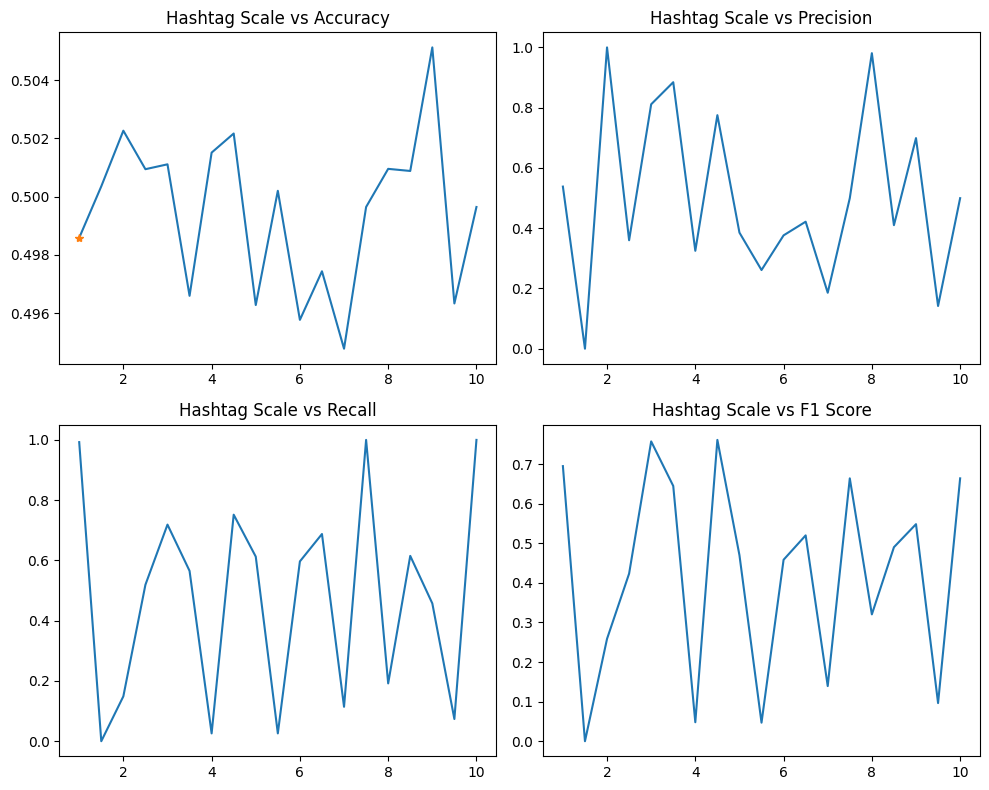

In [110]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot 1: Hashtag Scale vs Accuracy
axs[0, 0].set_title("Hashtag Scale vs Accuracy")
axs[0, 0].plot(np.linspace(1, 10, 19), scaled_accs)
axs[0, 0].plot(1, scaled_accs[0], '*')

# Plot 2: Hashtag Scale vs Precision
axs[0, 1].set_title("Hashtag Scale vs Precision")
axs[0, 1].plot(np.linspace(1, 10, 19), scaled_prec)

# Plot 3: Hashtag Scale vs Recall
axs[1, 0].set_title("Hashtag Scale vs Recall")
axs[1, 0].plot(np.linspace(1, 10, 19), scaled_recs)

# Plot 4: Hashtag Scale vs F1 Score
axs[1, 1].set_title("Hashtag Scale vs F1 Score")
axs[1, 1].plot(np.linspace(1, 10, 19), scaled_f1s)

# Adjust layout to prevent overlapping titles and labels
plt.tight_layout()

In [161]:
from sklearn.manifold import TSNE

labels = []
tokens = []
preds = []

for i in range(len(flattened_sigs)):
  tweet = flattened_test_tweets[i]
  # words = tweet.split()
  for idx in tweet:
    word = new_vectorizer.tokenizer.token_to_word[idx]
    if word in new_vectorizer.tokenizer.word_to_token and word not in labels and word[0]=='#':
      labels.append(word)
      j = new_vectorizer.tokenizer.word_to_token[word]
      tokens.append(reps_word2vec[j, :])
      preds.append(flattened_sigs[i])

# for i in vectorizer.tokenizer.token_to_word:
#   tokens.append(reps_word2vec[i, :])
#   labels.append(vectorizer.tokenizer.token_to_word[i])

tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(np.array(tokens))

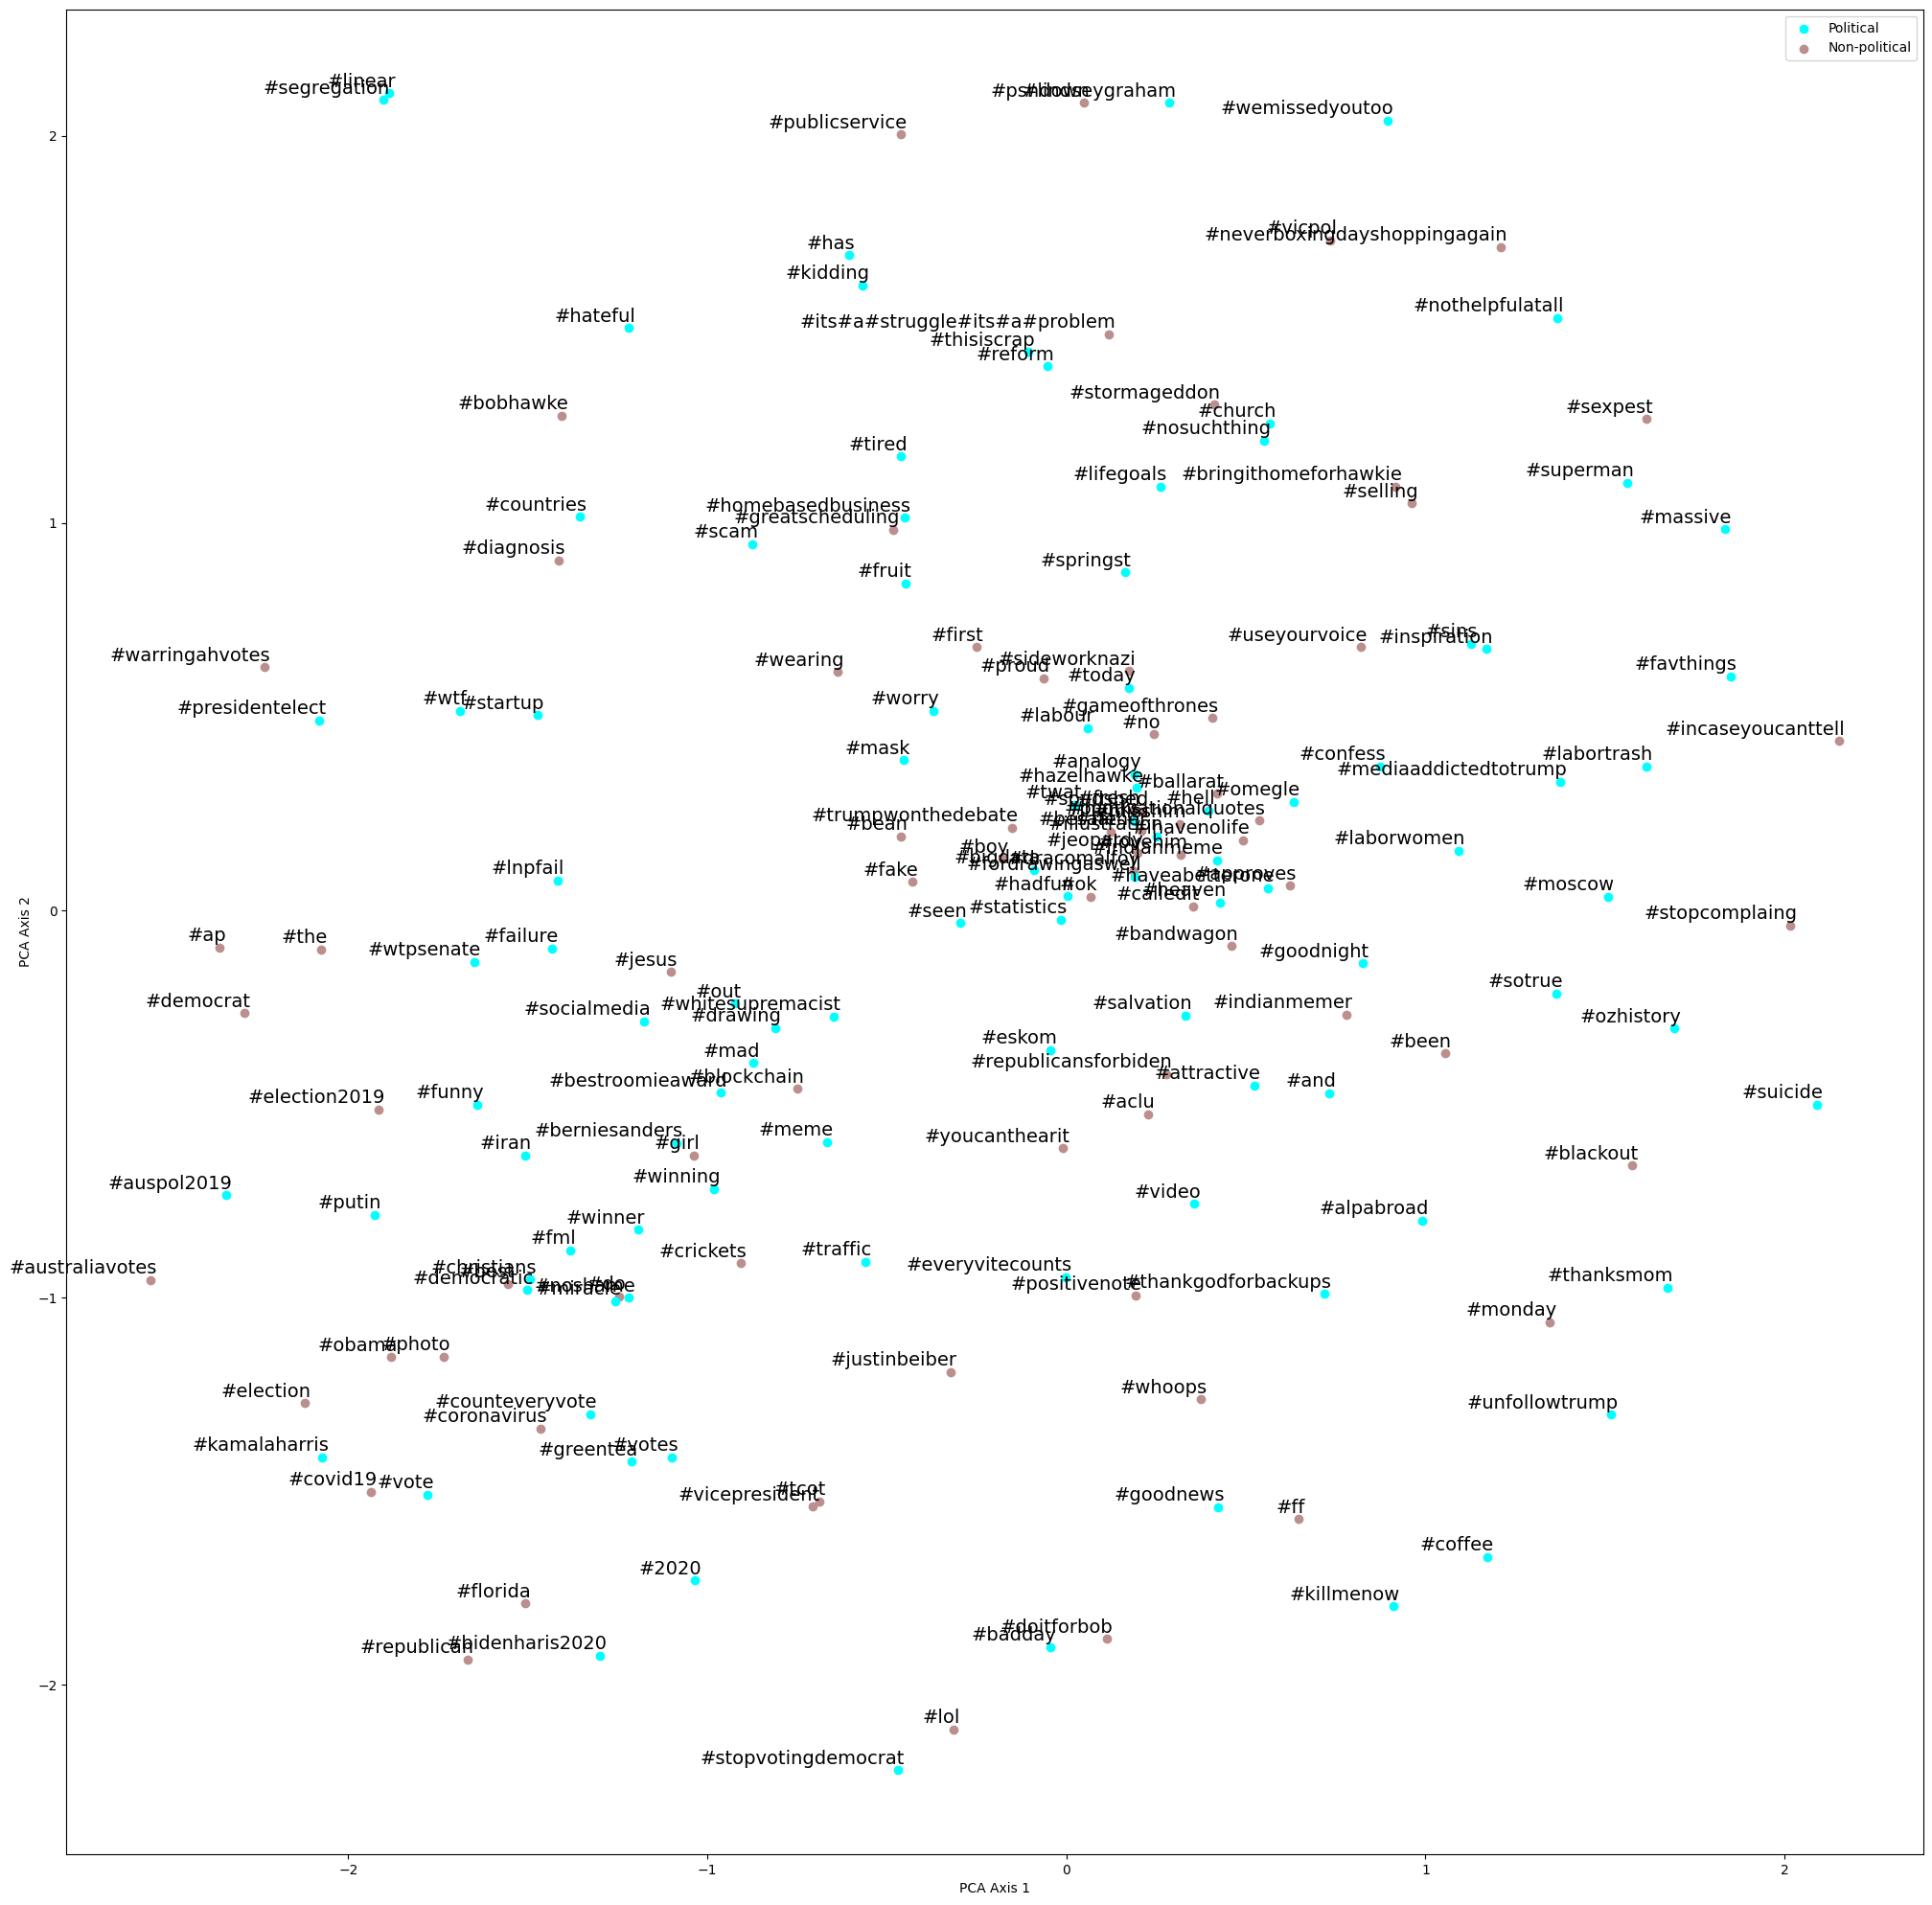

In [169]:
import matplotlib.pyplot as plt
x = []
y = []
colors = {
    0: 'rosybrown',
    1: 'cyan'
}
for value in new_values:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(25, 25))
seen0 = False
seen1 = False
for i in range(len(x)):
    label = 'Political' if preds[i] else 'Non-political'
    if preds[i]:
      label = 'Political'
      if not seen0:
        plt.scatter(x[i],y[i],c=colors[preds[i]], label=label)
        seen0 = True
      else:
        plt.scatter(x[i],y[i],c=colors[preds[i]])
    else:
      label = 'Non-political'
      if not seen1:
        plt.scatter(x[i],y[i],c=colors[preds[i]], label=label)
        seen1 = True
      else:
        plt.scatter(x[i],y[i],c=colors[preds[i]])
    plt.annotate(labels[i],
                  xy=(x[i], y[i]),
                  xytext=(5, 2),
                  textcoords='offset points',
                  ha='right',
                  va='bottom',
                 size=14)
plt.xlabel('PCA Axis 1')
plt.ylabel('PCA Axis 2')
plt.legend()
plt.show()